In [4]:
setwd(paste0(Sys.getenv('R_SOURCES'), '/house_prices'))
getwd()

[1] "/mnt/hdd/develop/kaggle/R_sources/house_prices"

In [5]:
source('main.R')
house_prices$helpers$import_libs()

combined_dataset <- house_prices$helpers$load_data()

combined_dataset_fixed <-
    combined_dataset %>%
    (house_prices$missing$categ$replace_with_most_common) %>%
    (house_prices$missing$categ$fix_valid) %>%
    (house_prices$missing$numeric$replace_with_zero)

combined_dataset_fixed %>% purrr::map(~sum(is.na(.)) > 0) %>% purrr::keep(~.)

$SalePrice
[1] TRUE

In [66]:
categ_data <- 
    combined_dataset_fixed %>%
    # select categ vars
    select(house_prices$helpers$get_character_colnames(combined_dataset_fixed), SalePrice, -dataSource) %>%
    # drop weak categ vars
    select(-one_of(house_prices$attributes_selection$discared_cat_vars)) %>%
    filter(!is.na(SalePrice)) %>%
    mutate(
        price_log = log(SalePrice)
    ) %>%
    select(-SalePrice)

categ_data %>% colnames %>% sort

[1] "Alley"         "BldgType"      "BsmtCond"      "BsmtExposure" 
 [5] "BsmtFinType1"  "BsmtQual"      "CentralAir"    "Electrical"   
 [9] "Exterior1st"   "Exterior2nd"   "ExterQual"     "Fence"        
[13] "FireplaceQu"   "Foundation"    "GarageCond"    "GarageFinish" 
[17] "GarageQual"    "GarageType"    "HeatingQC"     "HouseStyle"   
[21] "KitchenQual"   "LandContour"   "LotConfig"     "LotShape"     
[25] "MasVnrType"    "MiscFeature"   "MSSubClass"    "MSZoning"     
[29] "Neighborhood"  "PavedDrive"    "PoolQC"        "price_log"    
[33] "RoofStyle"     "SaleCondition" "SaleType"

In [141]:
source('main.R')
order_factor_by_target <- house_prices$attributes_selection$order_factor_by_target

doit <- function(var) {
    
    var <- enquo(var)
    var_char <- as.character(var)[2]
    
    order_factor_by_target(
        df = categ_data %>% select(!!var, price_log), 
        factor_var = !!var, 
        target_var = price_log,
        fn = median
    ) -> aaa

    aaa %>%
    select(!!var, price_log) %>%
    group_by(!!var) %>%
    summarise(
        n = n(),
        median = median(price_log)
    ) -> bbb
    
    bbb %>% print

    aaa %>% 
    ggplot() +
    geom_density(aes_string("price_log", y="..scaled..", fill=var_char, color=var_char), alpha=0.2) +
    facet_wrap(as.formula(paste0("~", var_char)), nrow=1) +
    geom_vline(aes(xintercept=median), data=bbb) +
    coord_flip() +
    theme_bw() +
    theme(legend.position="bottom")
}

# A tibble: 3 x 3
   Alley     n   median
  <fctr> <int>    <dbl>
1   Grvl    50 11.69106
2 _none_  1369 12.01370
3   Pave    41 12.05815


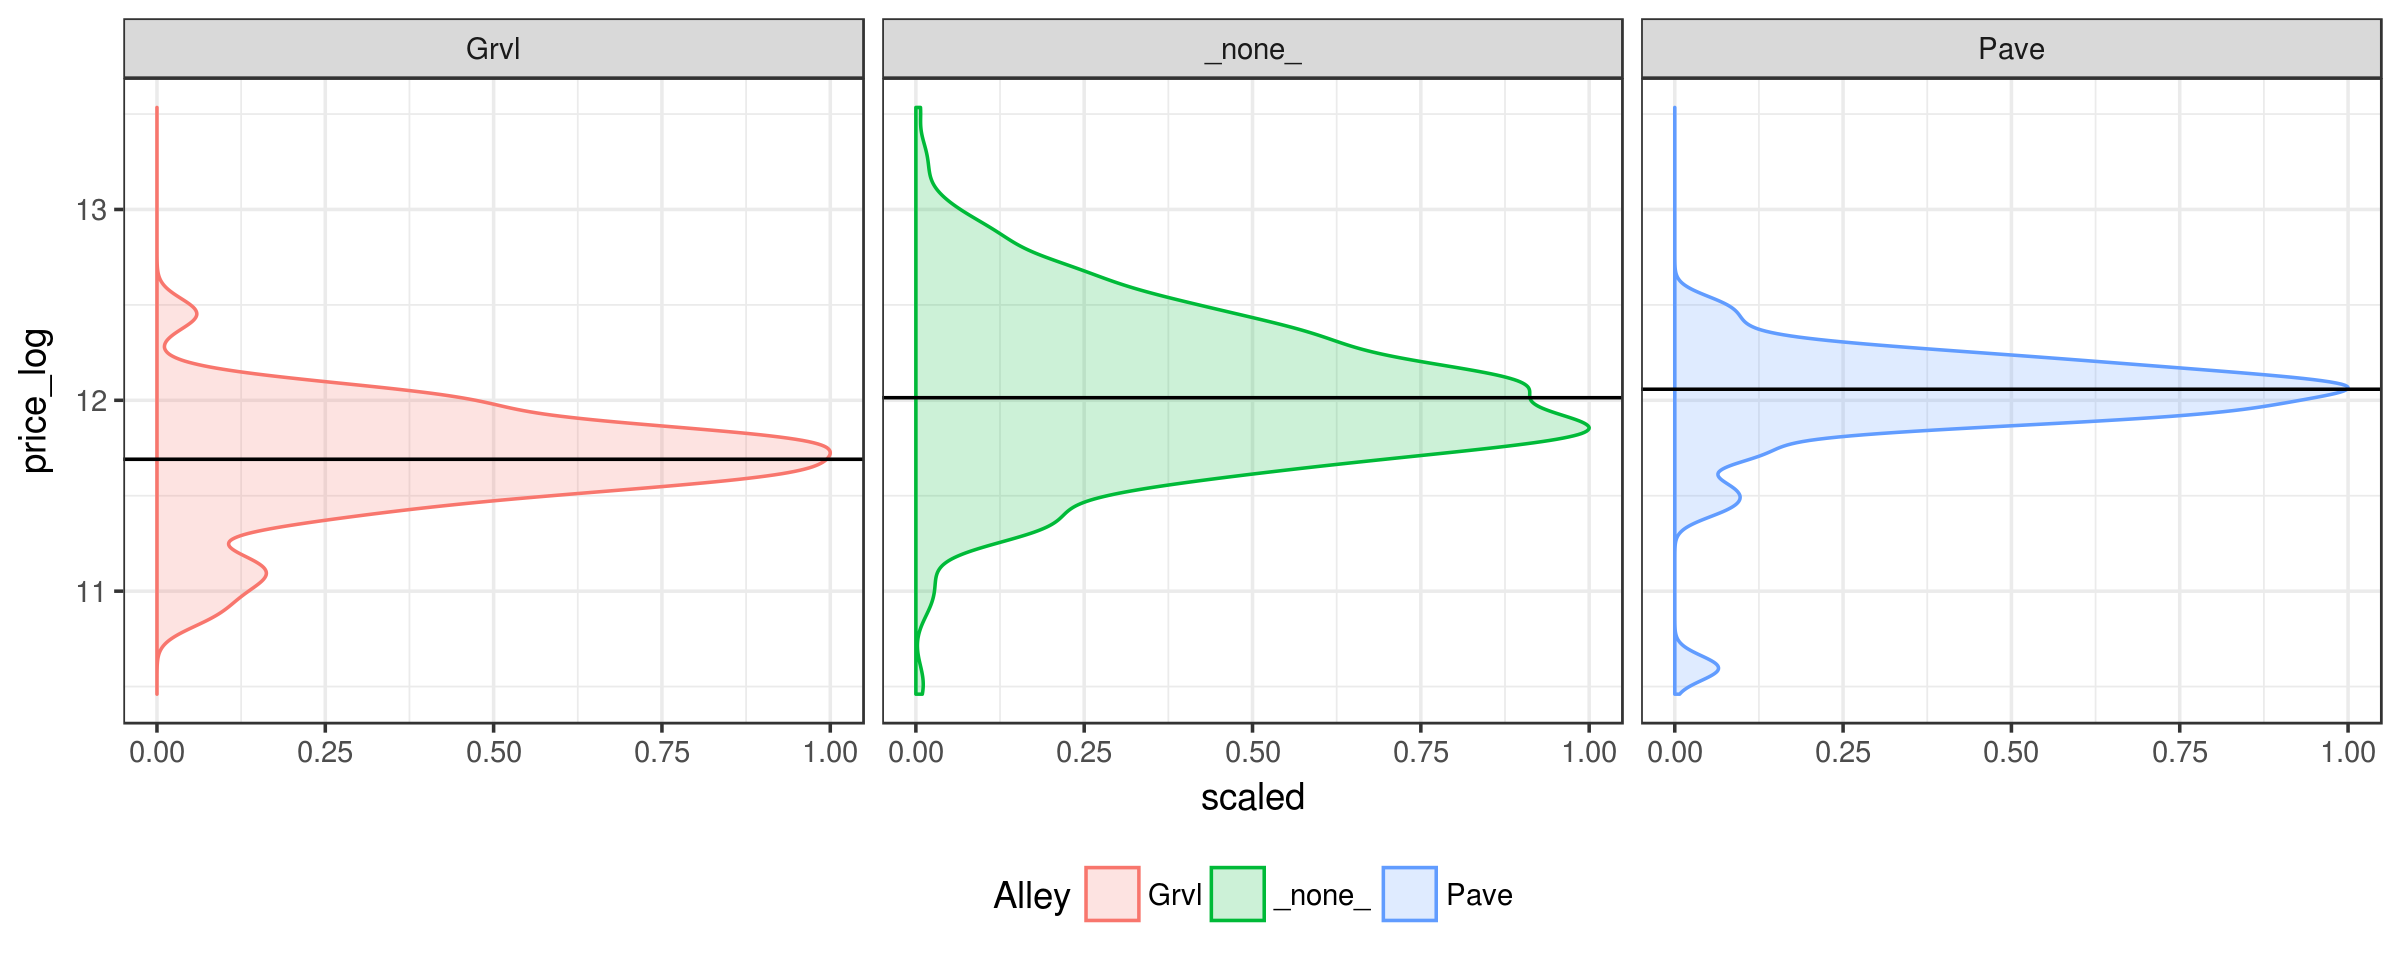

In [142]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res=240)
# discarded
doit(Alley)

# A tibble: 5 x 3
  BldgType     n   median
    <fctr> <int>    <dbl>
1   2fmCon    31 11.75587
2   Duplex    52 11.82026
3    Twnhs    43 11.83138
4     1Fam  1220 12.03112
5   TwnhsE   114 12.05641


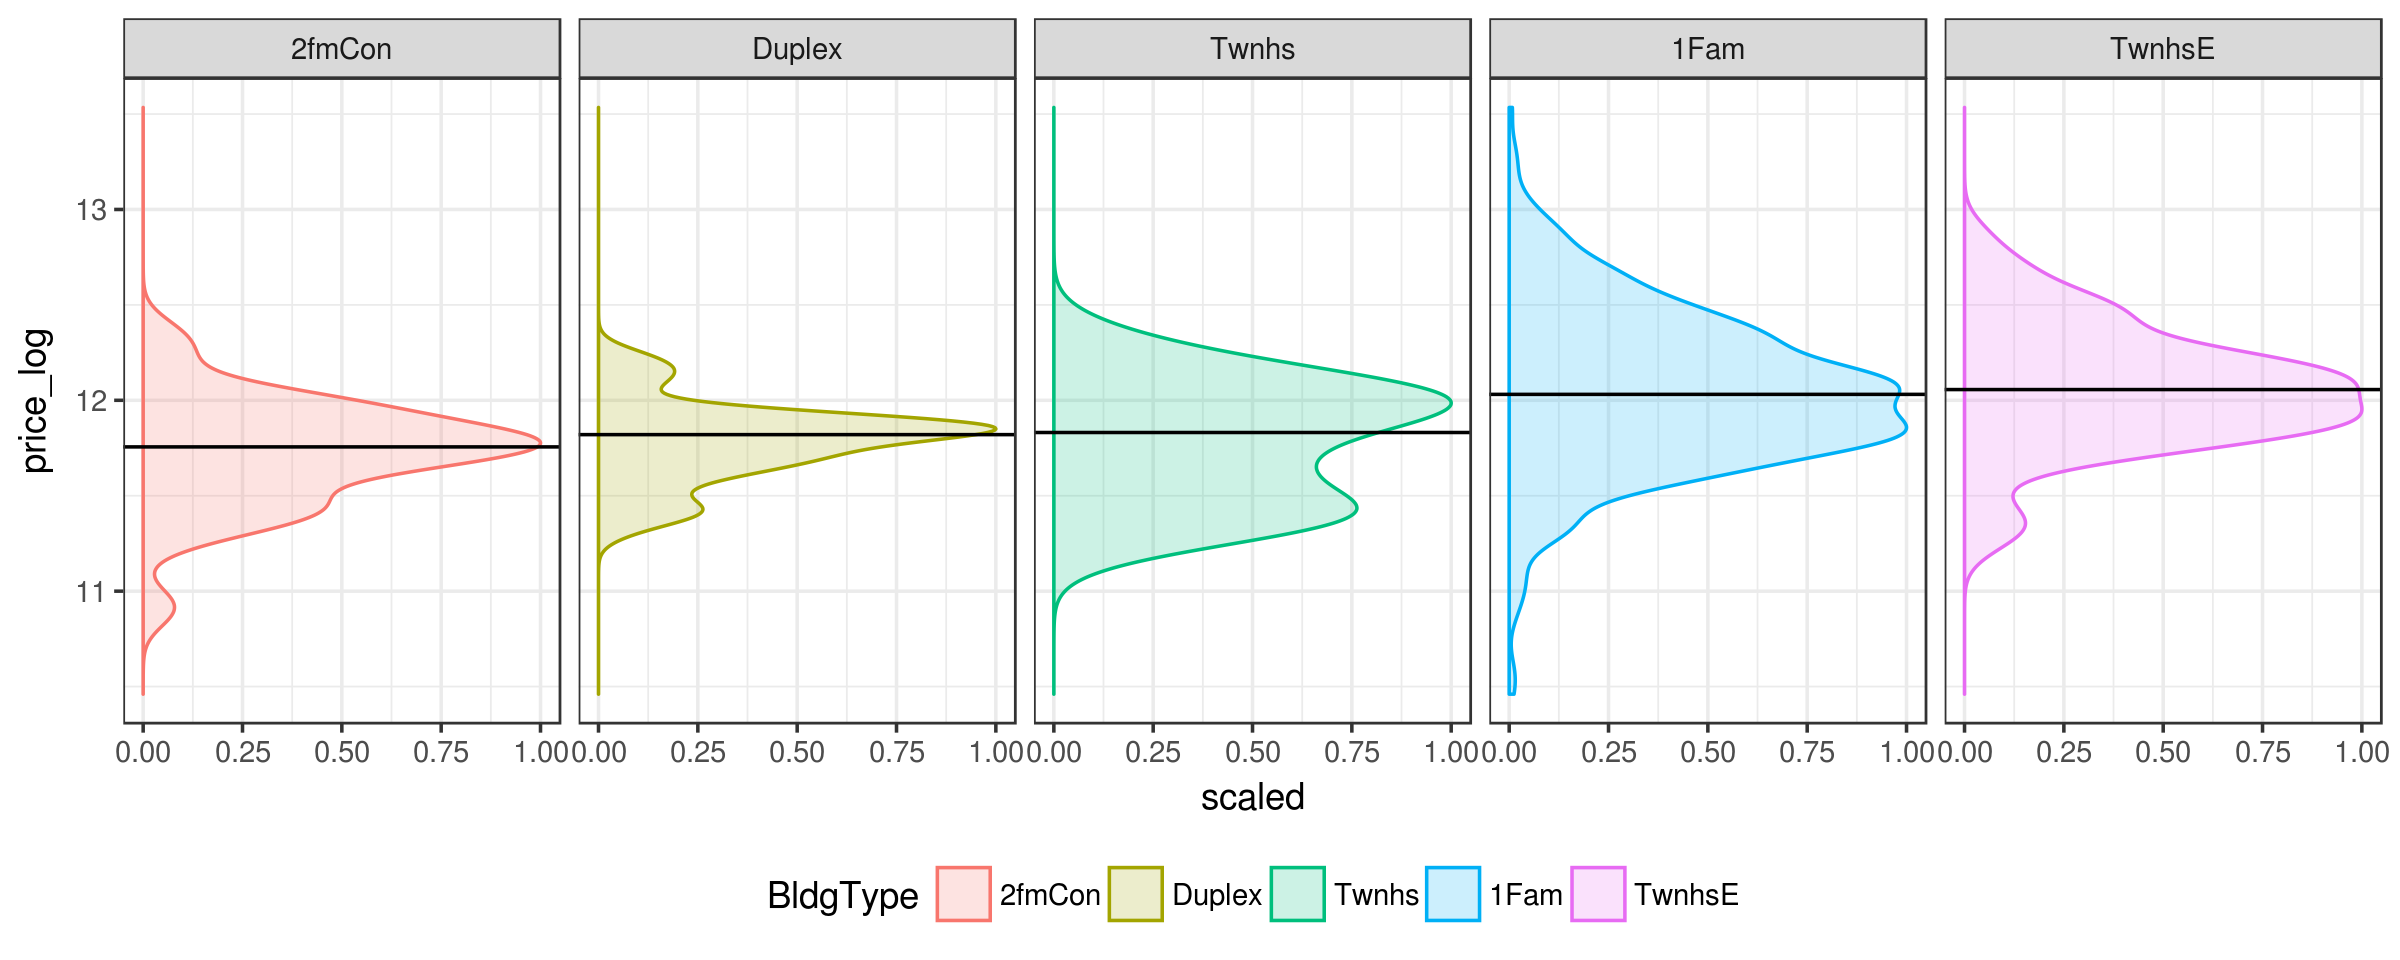

In [143]:
doit(BldgType)

# A tibble: 5 x 3
  BsmtCond     n   median
    <fctr> <int>    <dbl>
1       Po     2 11.06554
2   _none_    37 11.53077
3       Fa    45 11.68267
4       TA  1311 12.01370
5       Gd    65 12.17499


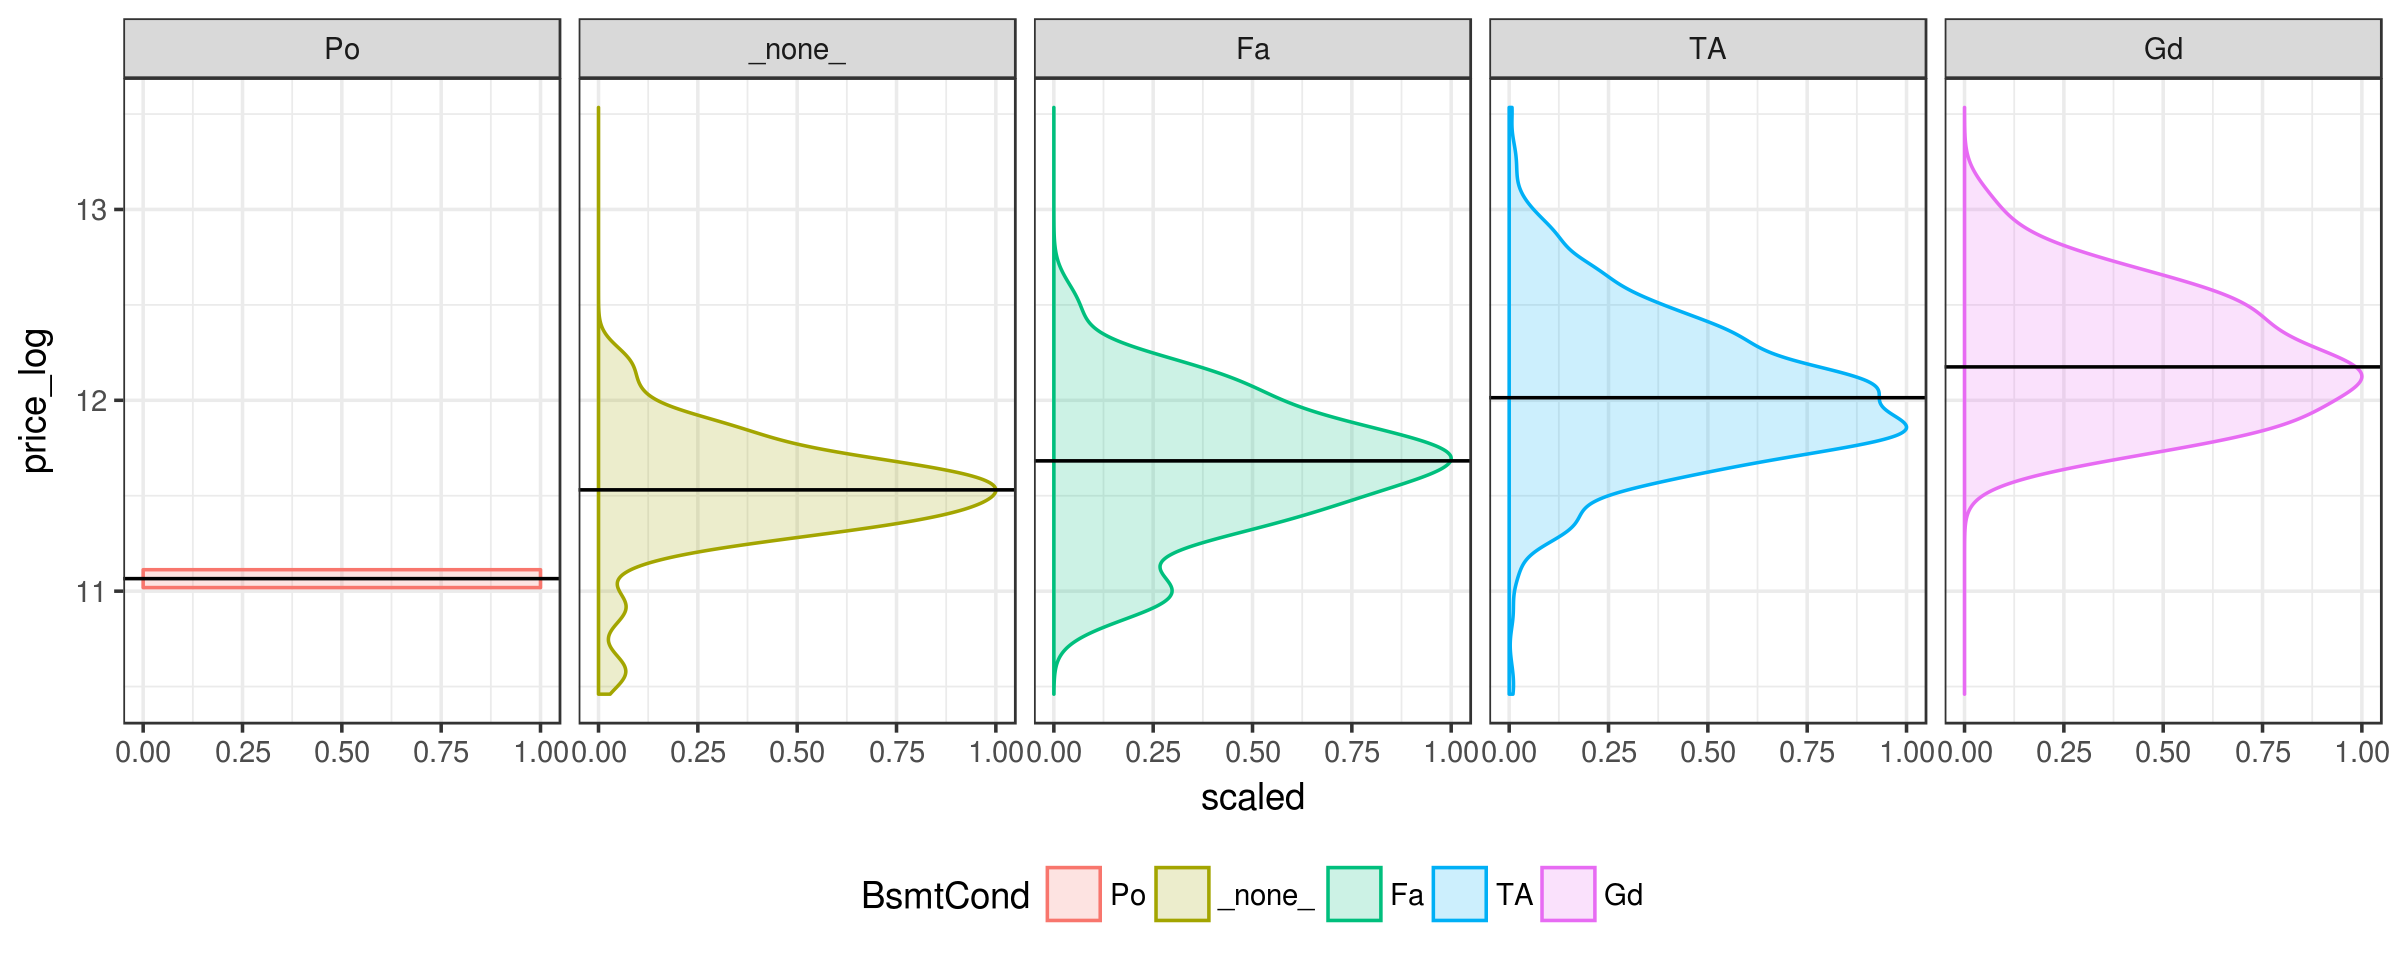

In [144]:
# discarded
doit(BsmtCond)

# A tibble: 5 x 3
  BsmtExposure     n   median
        <fctr> <int>    <dbl>
1       _none_    38 11.55216
2           No   953 11.94471
3           Mn   114 12.11413
4           Av   221 12.13270
5           Gd   134 12.33256


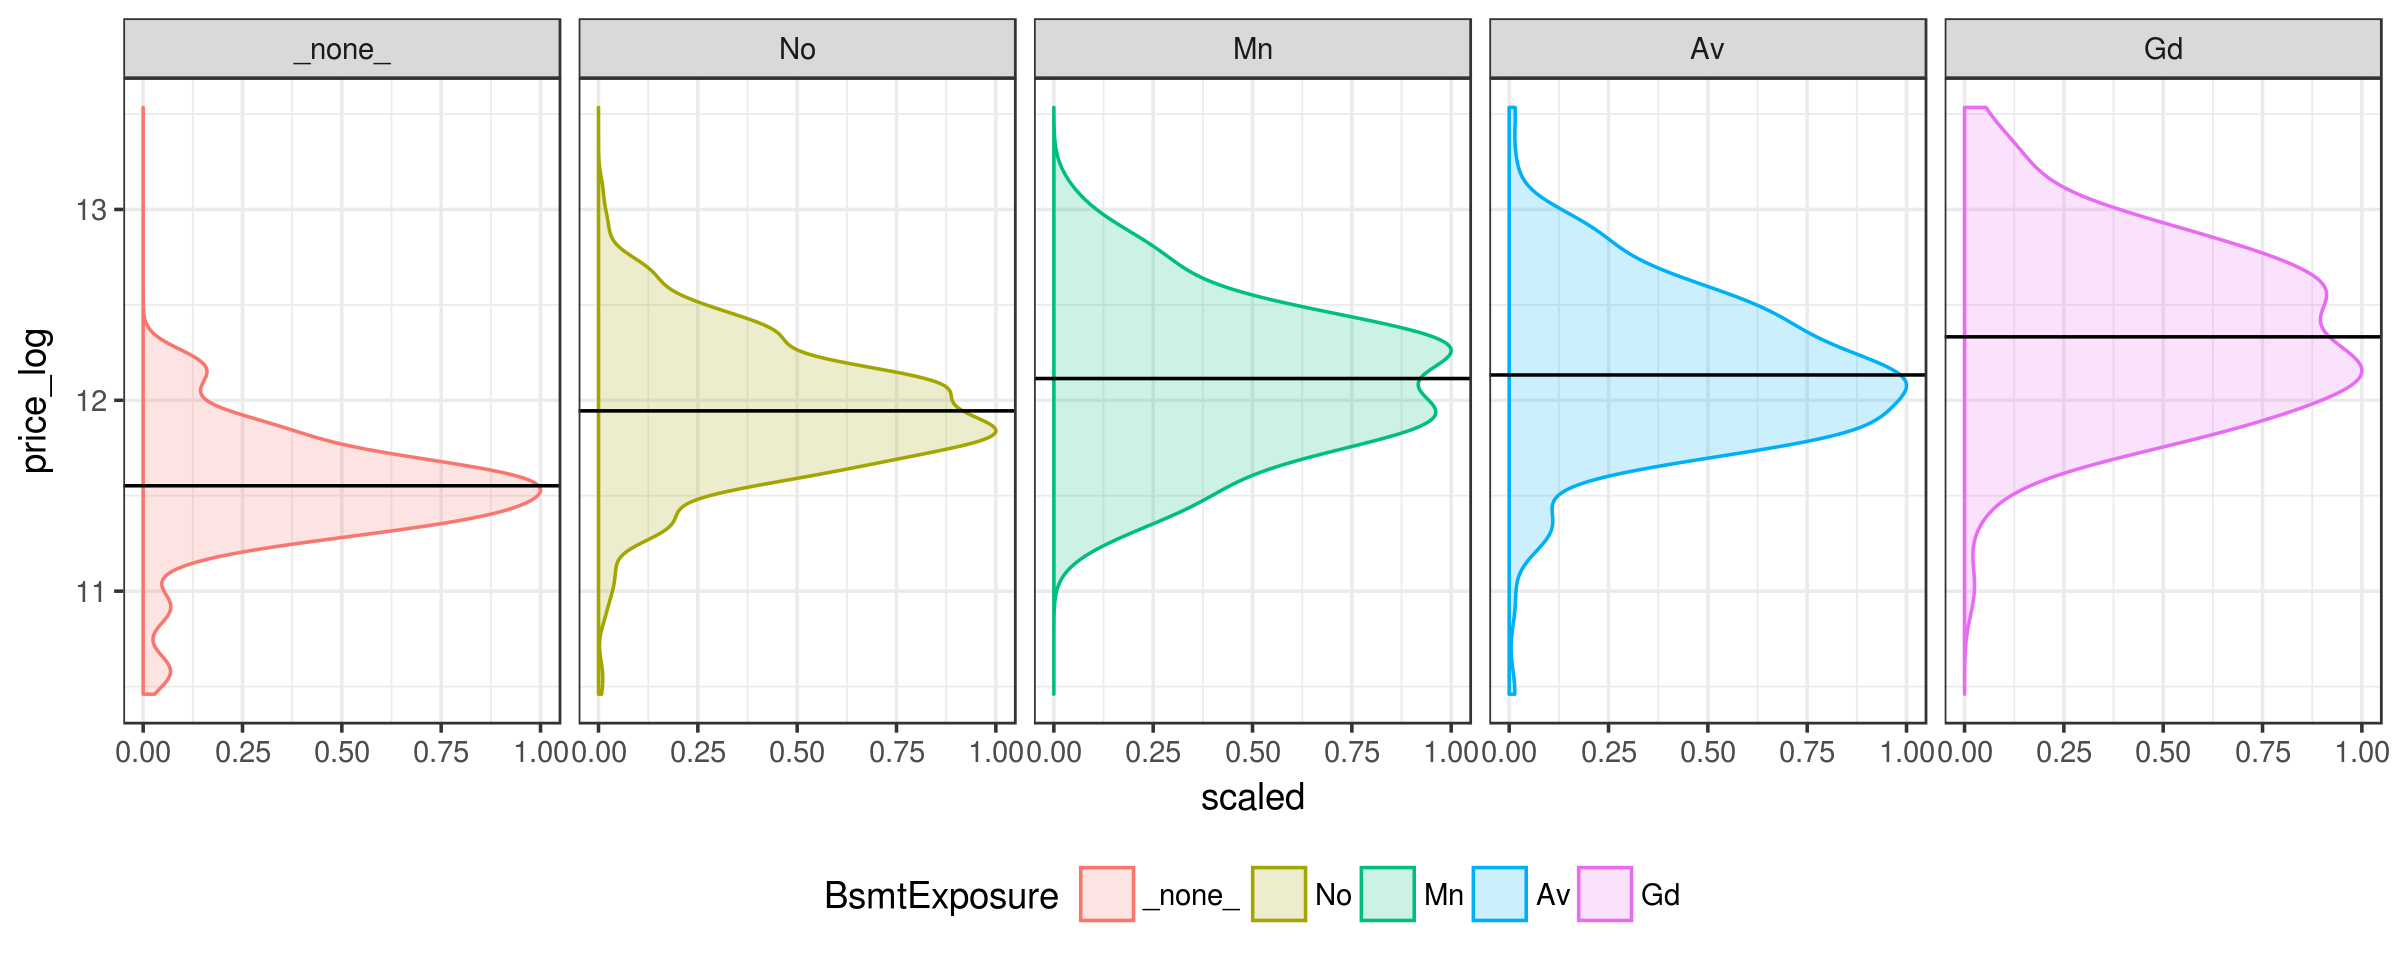

In [145]:
doit(BsmtExposure)

# A tibble: 7 x 3
  BsmtFinType1     n   median
        <fctr> <int>    <dbl>
1       _none_    37 11.53077
2          LwQ    74 11.84223
3          BLQ   148 11.84295
4          Rec   133 11.86358
5          ALQ   220 11.91338
6          Unf   430 11.99381
7          GLQ   418 12.27256


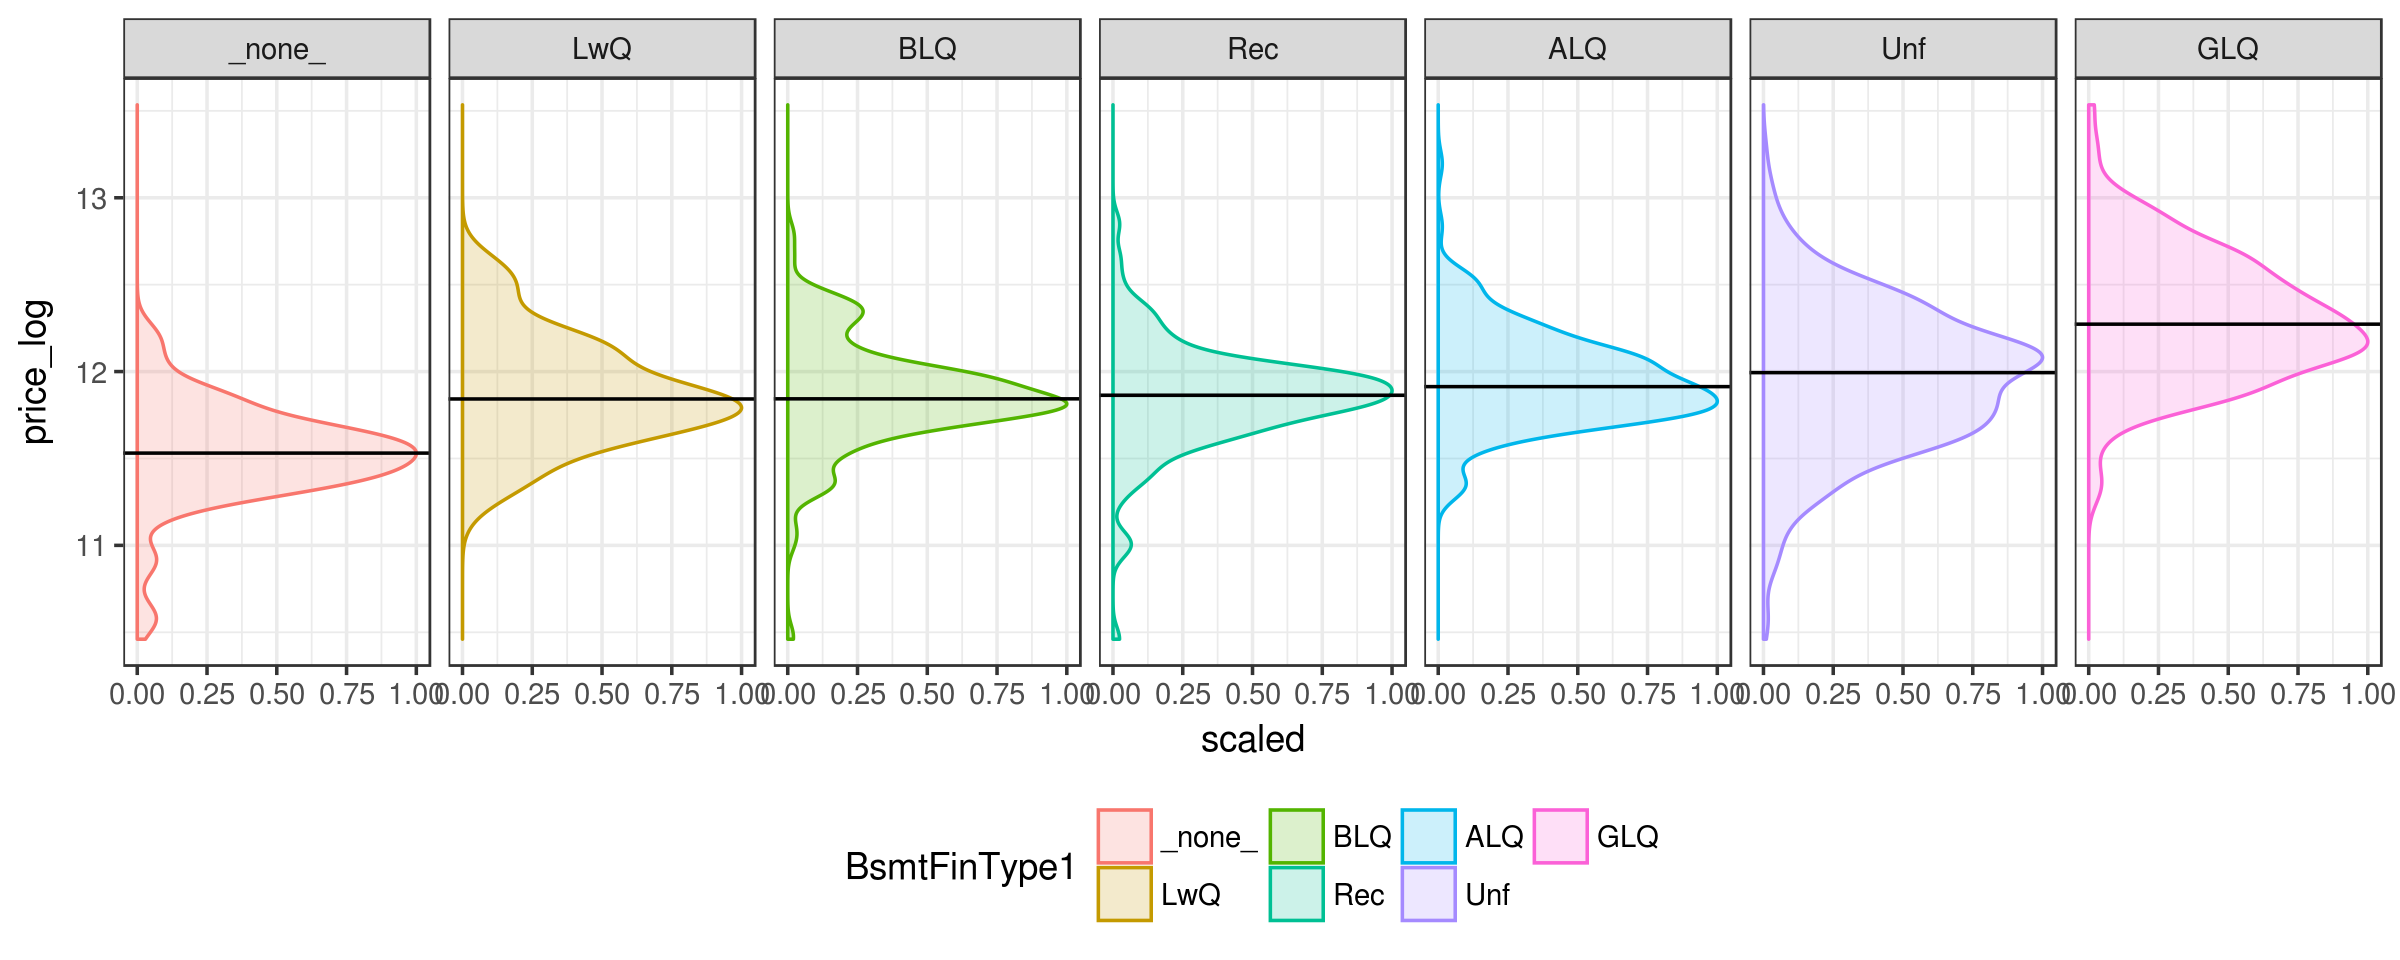

In [146]:
doit(BsmtFinType1)

# A tibble: 5 x 3
  BsmtQual     n     mean
    <fctr> <int>    <dbl>
1   _none_    37 11.52968
2       Fa    35 11.61760
3       TA   649 11.81086
4       Gd   618 12.17988
5       Ex   121 12.64039


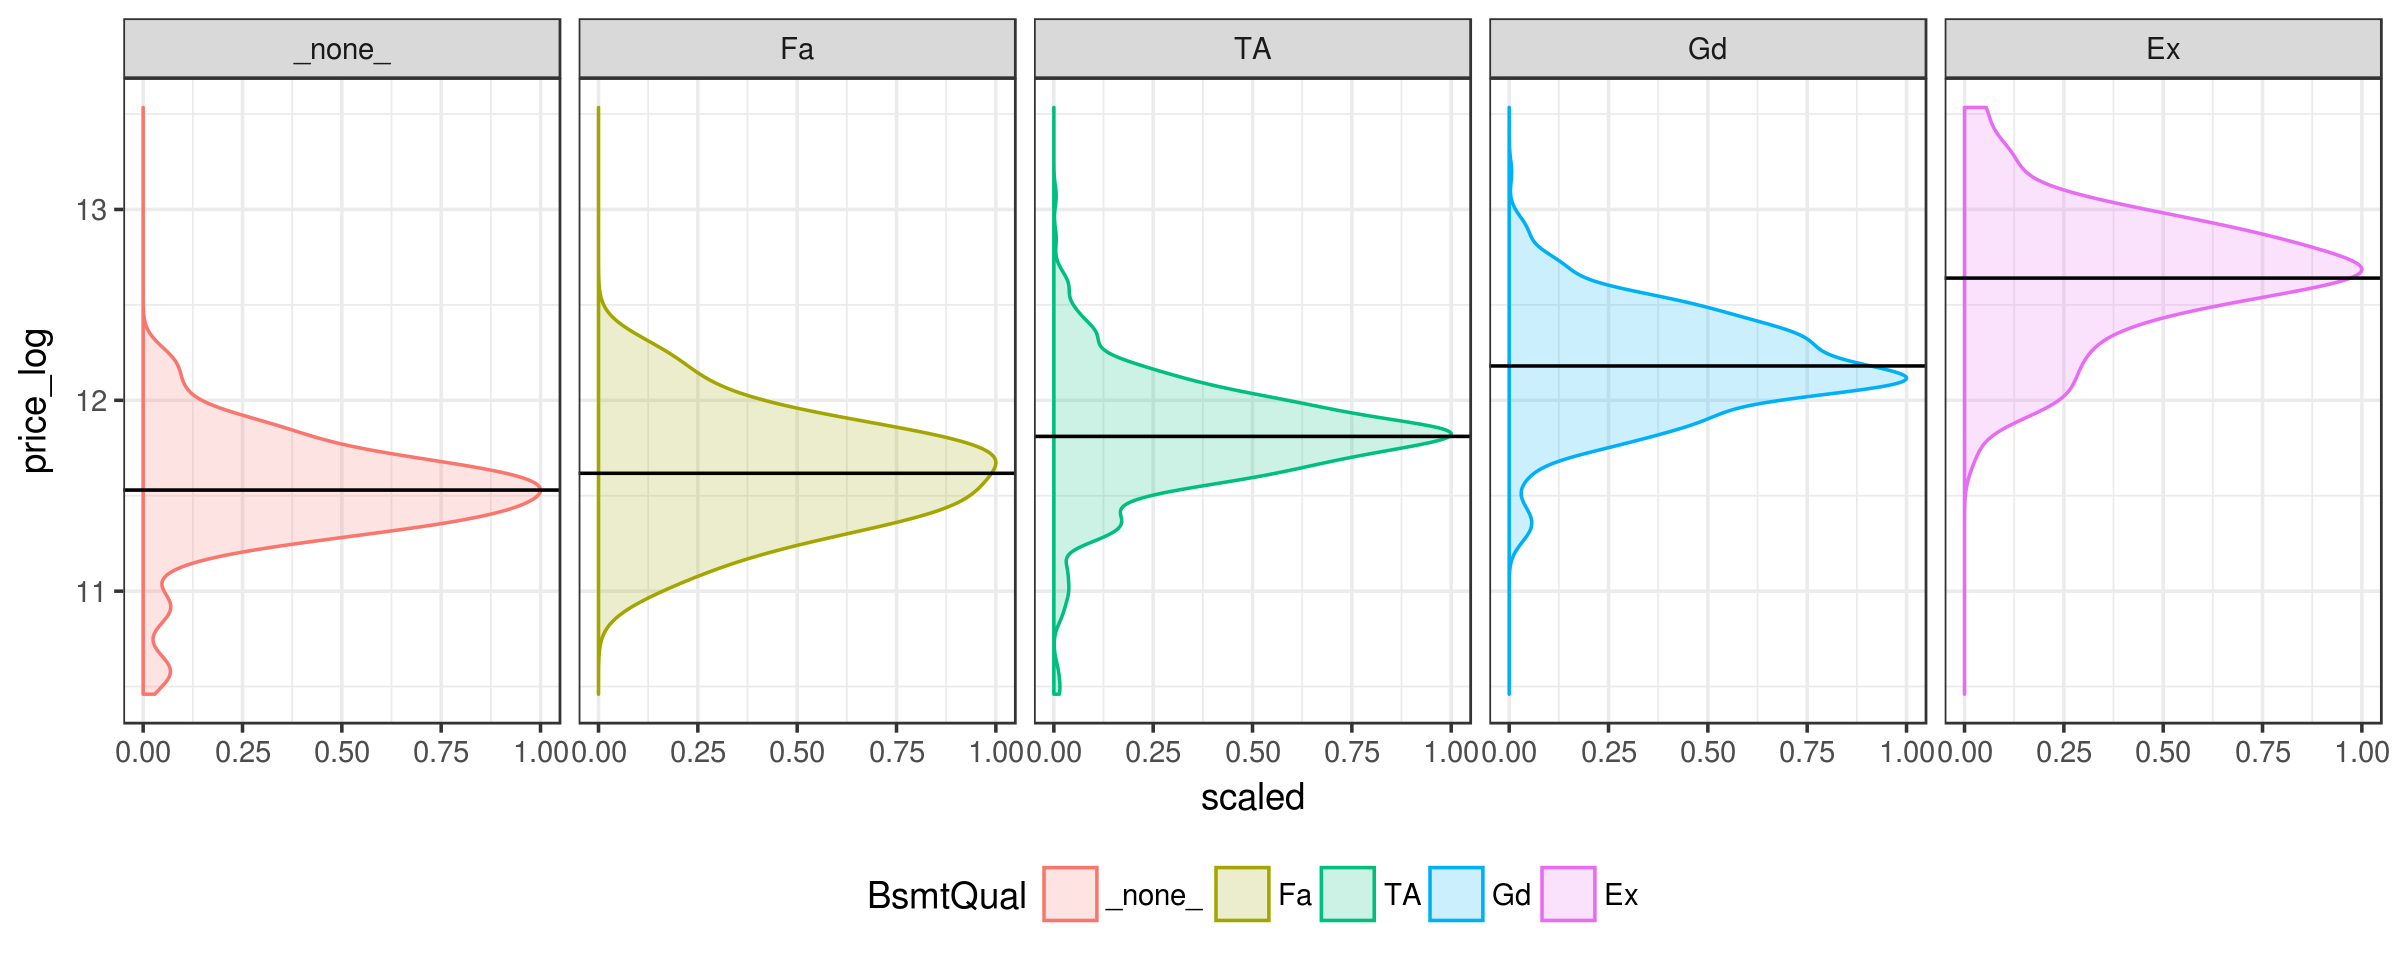

In [114]:
doit(BsmtQual)

# A tibble: 2 x 3
  CentralAir     n     mean
      <fctr> <int>    <dbl>
1          N    95 11.49186
2          Y  1365 12.06109


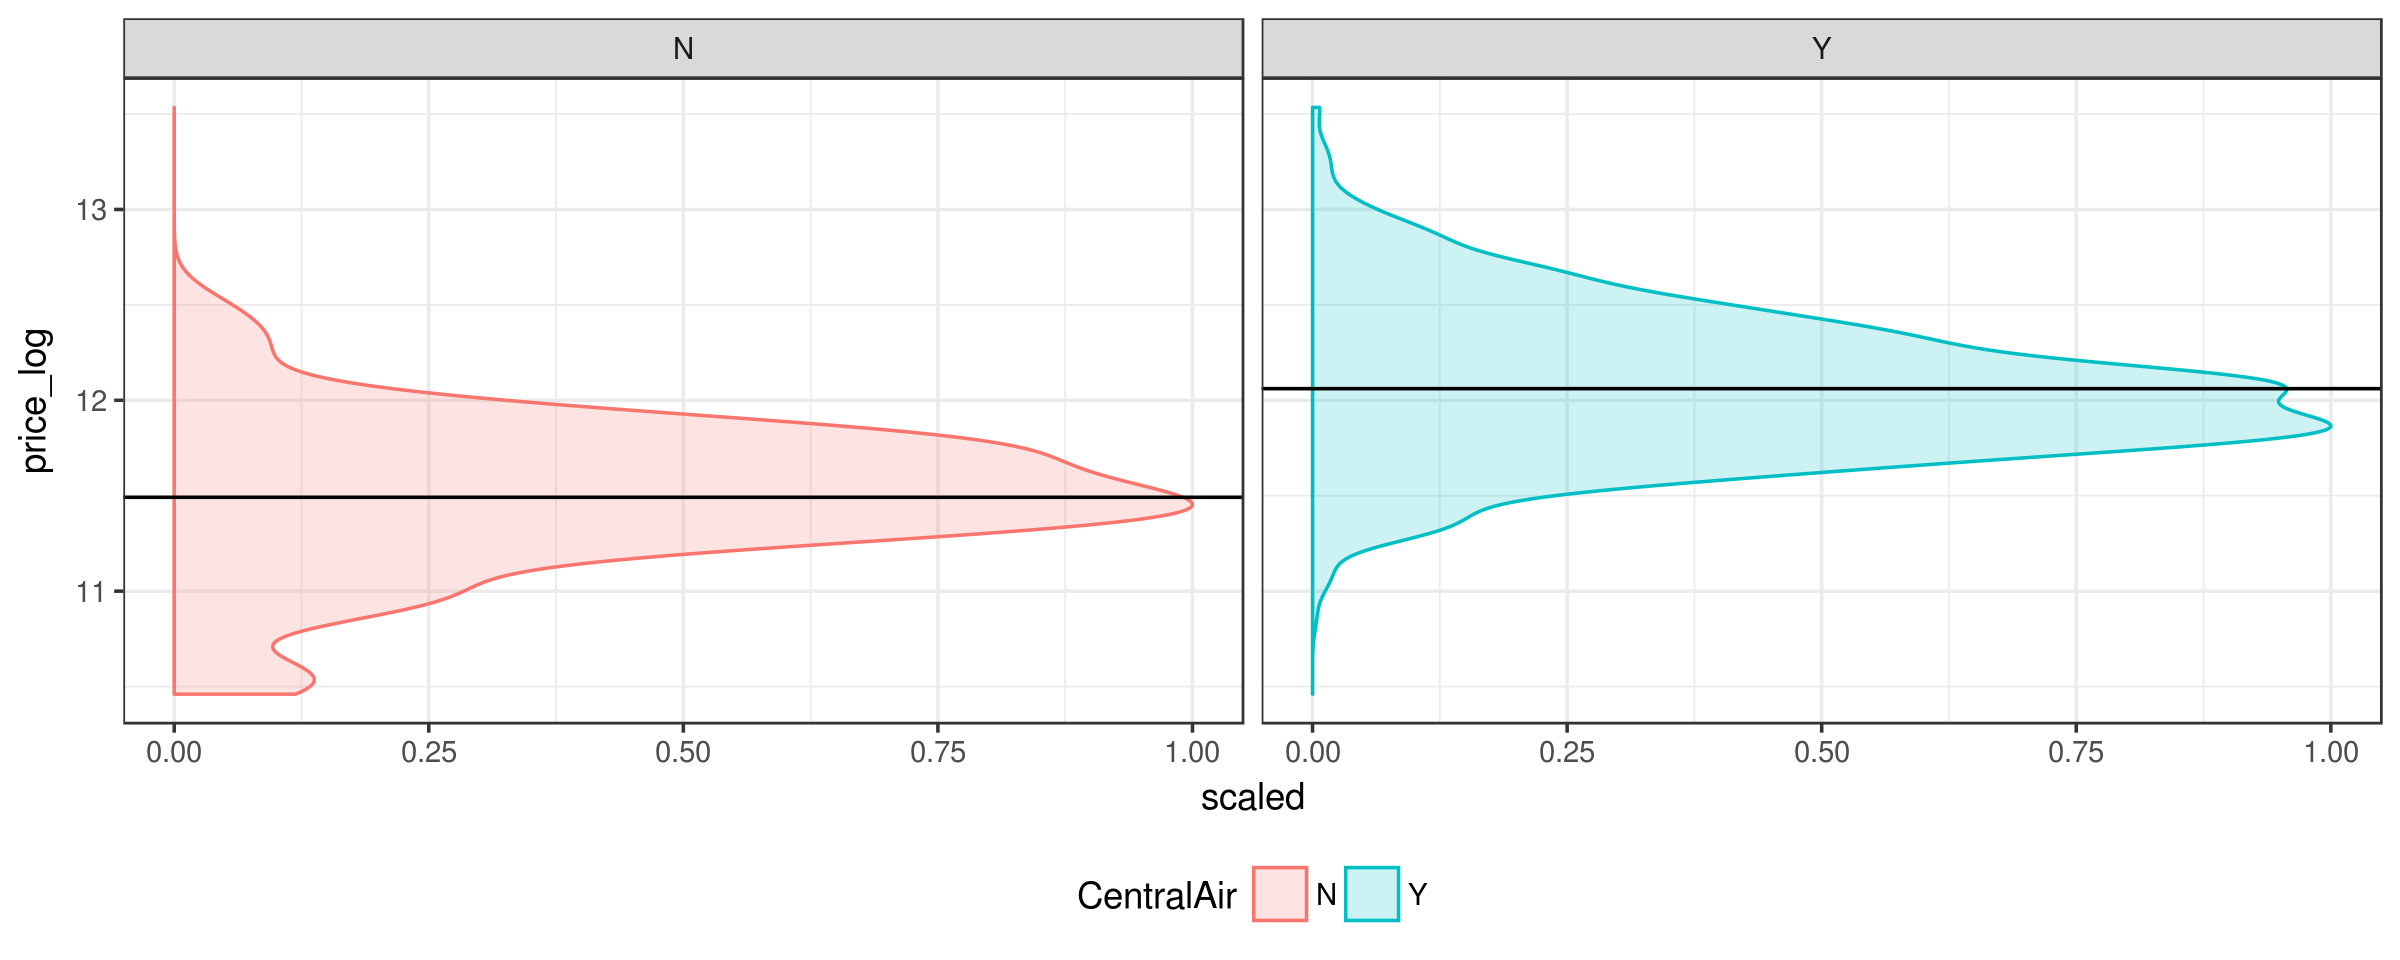

In [117]:
doit(CentralAir)

# A tibble: 5 x 3
  Electrical     n     mean
      <fctr> <int>    <dbl>
1        Mix     1 11.11245
2      FuseP     3 11.44681
3      FuseF    27 11.53962
4      FuseA    94 11.66032
5      SBrkr  1335 12.06144


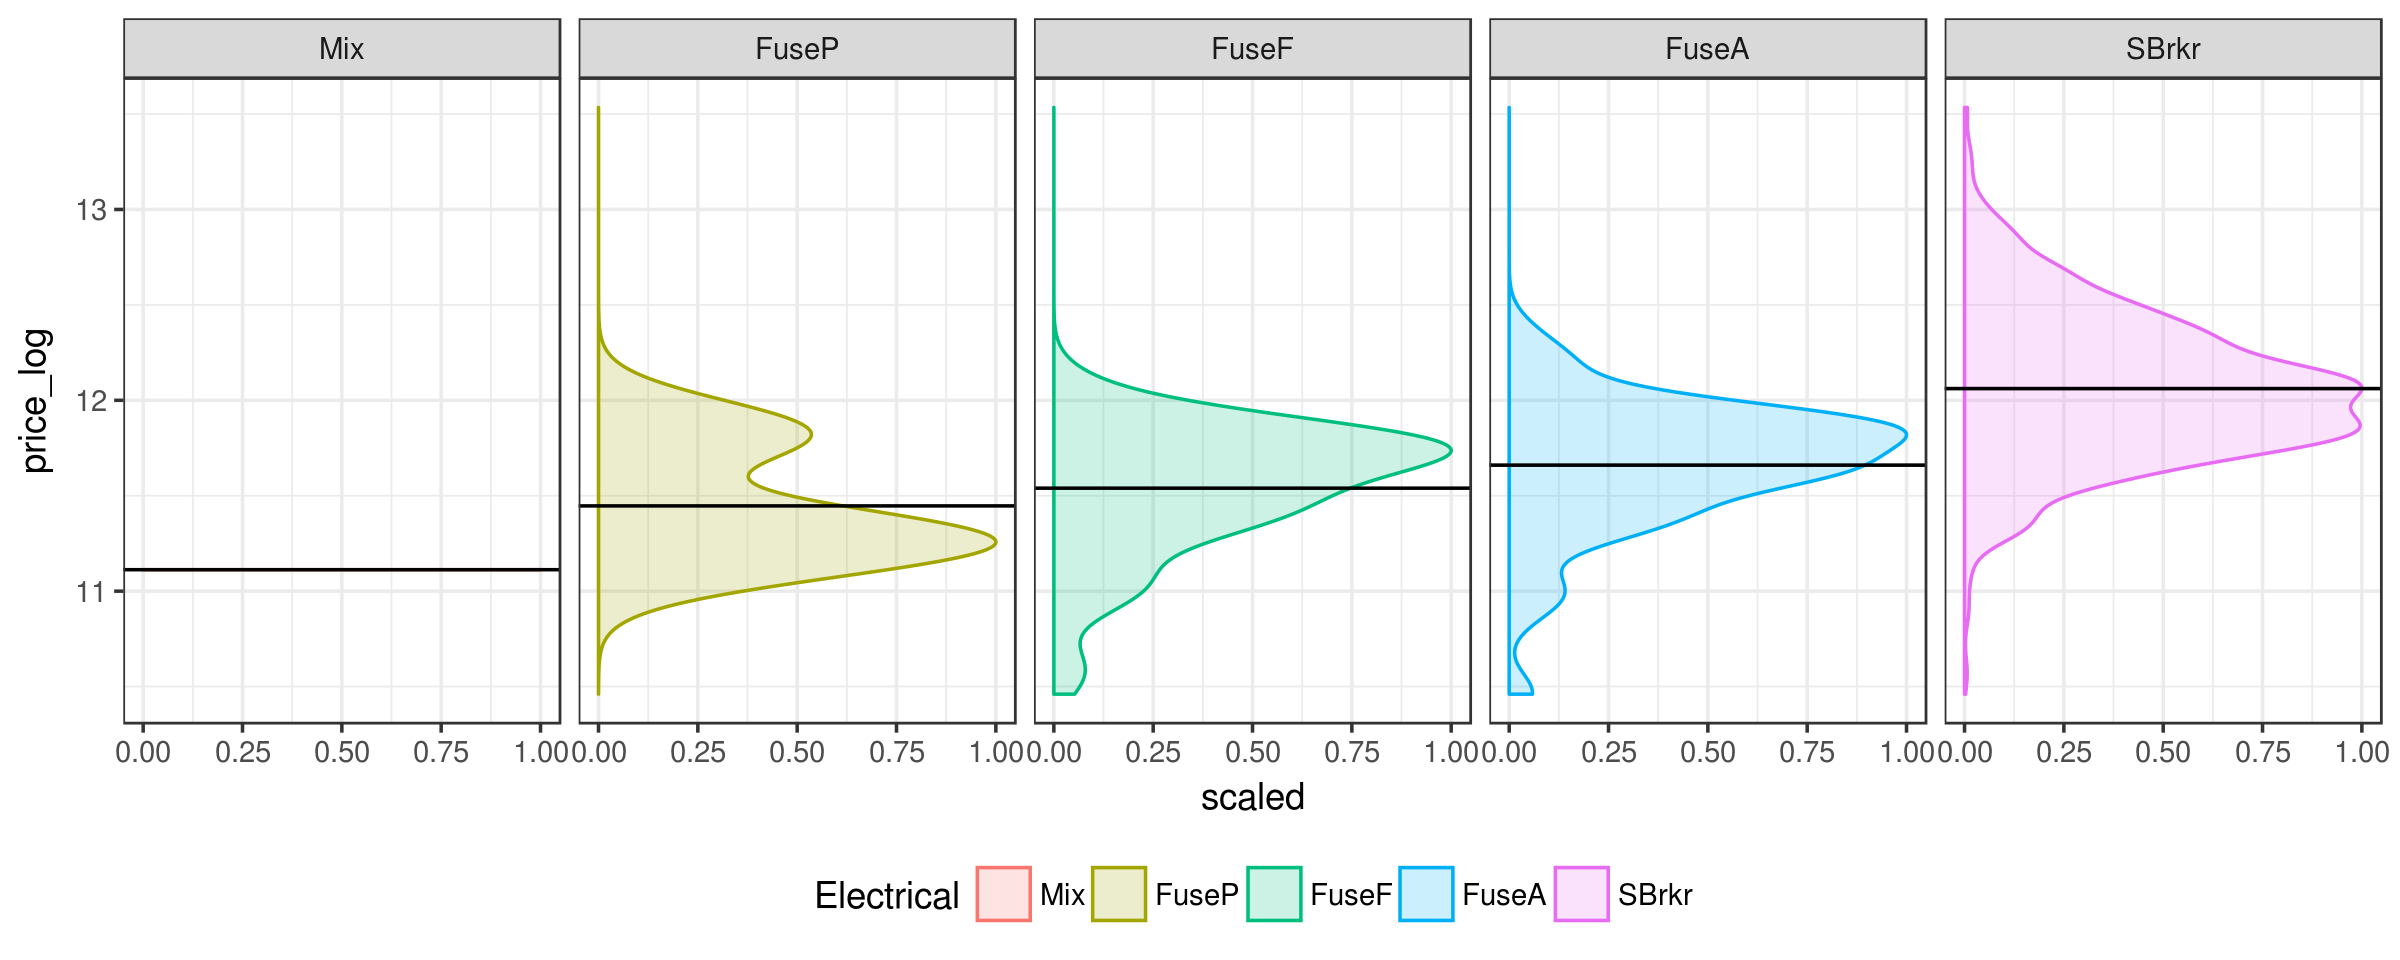

In [118]:
doit(Electrical)

# A tibble: 15 x 3
   Exterior1st     n     mean
        <fctr> <int>    <dbl>
 1     BrkComm     2 11.15829
 2     AsphShn     1 11.51293
 3     AsbShng    20 11.52451
 4      CBlock     1 11.56172
 5     Wd Sdng   206 11.83851
 6     WdShing    26 11.84454
 7     MetalSd   220 11.85977
 8      Stucco    25 11.89199
 9     HdBoard   222 11.95190
10     Plywood   108 12.04122
11     BrkFace    50 12.08814
12     CemntBd    61 12.20492
13     VinylSd   515 12.20587
14       Stone     2 12.45654
15     ImStucc     1 12.47610


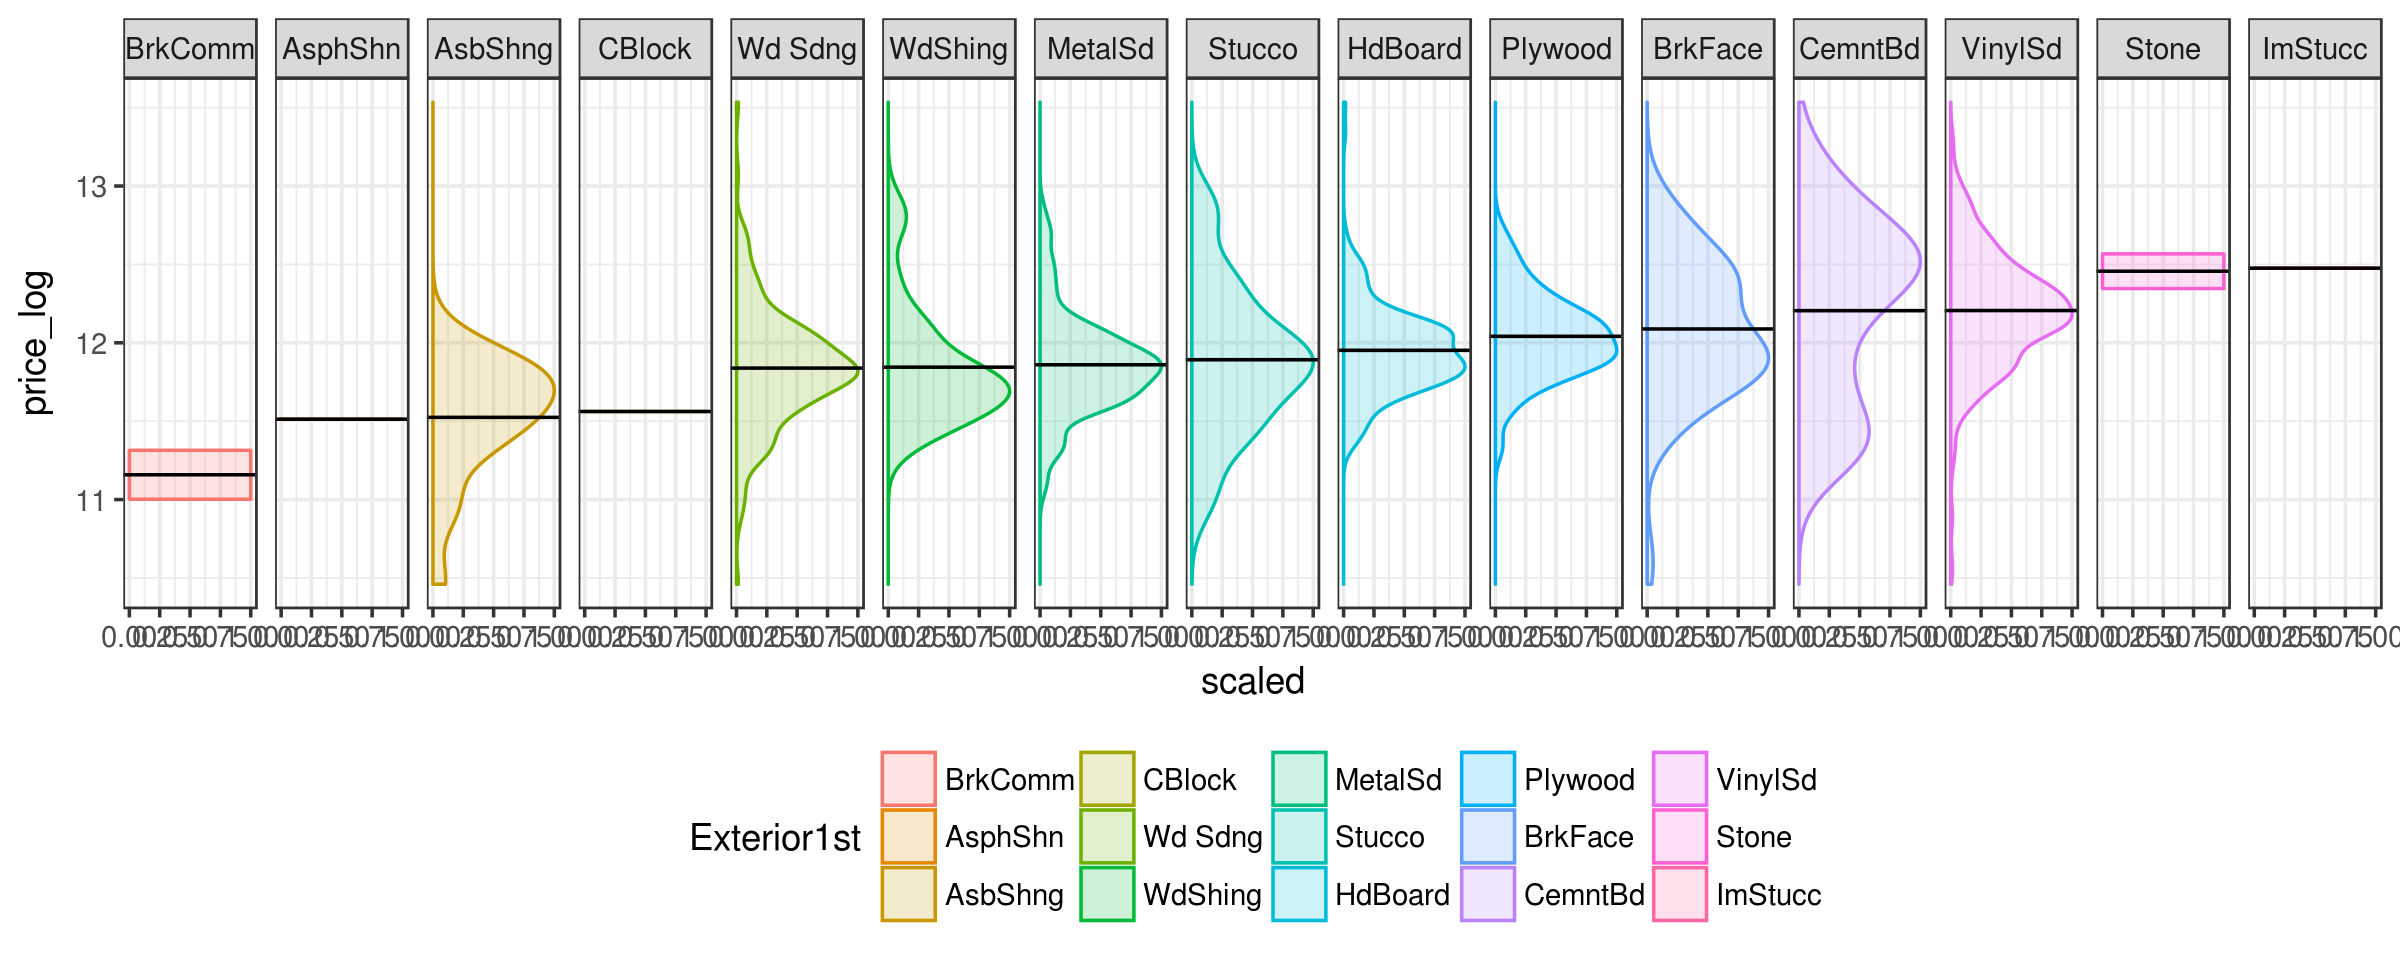

In [119]:
doit(Exterior1st)

# A tibble: 16 x 3
   Exterior2nd     n     mean
        <fctr> <int>    <dbl>
 1      CBlock     1 11.56172
 2     AsbShng    20 11.57022
 3     Brk Cmn     7 11.69628
 4     AsphShn     3 11.80923
 5     Wd Sdng   197 11.83848
 6      Stucco    26 11.85303
 7     MetalSd   214 11.86229
 8     Wd Shng    38 11.89224
 9       Stone     5 11.89844
10     HdBoard   207 11.97493
11     Plywood   142 11.99474
12     BrkFace    25 12.06607
13     CmentBd    60 12.20195
14     VinylSd   504 12.20963
15     ImStucc    10 12.24006
16       Other     1 12.67295


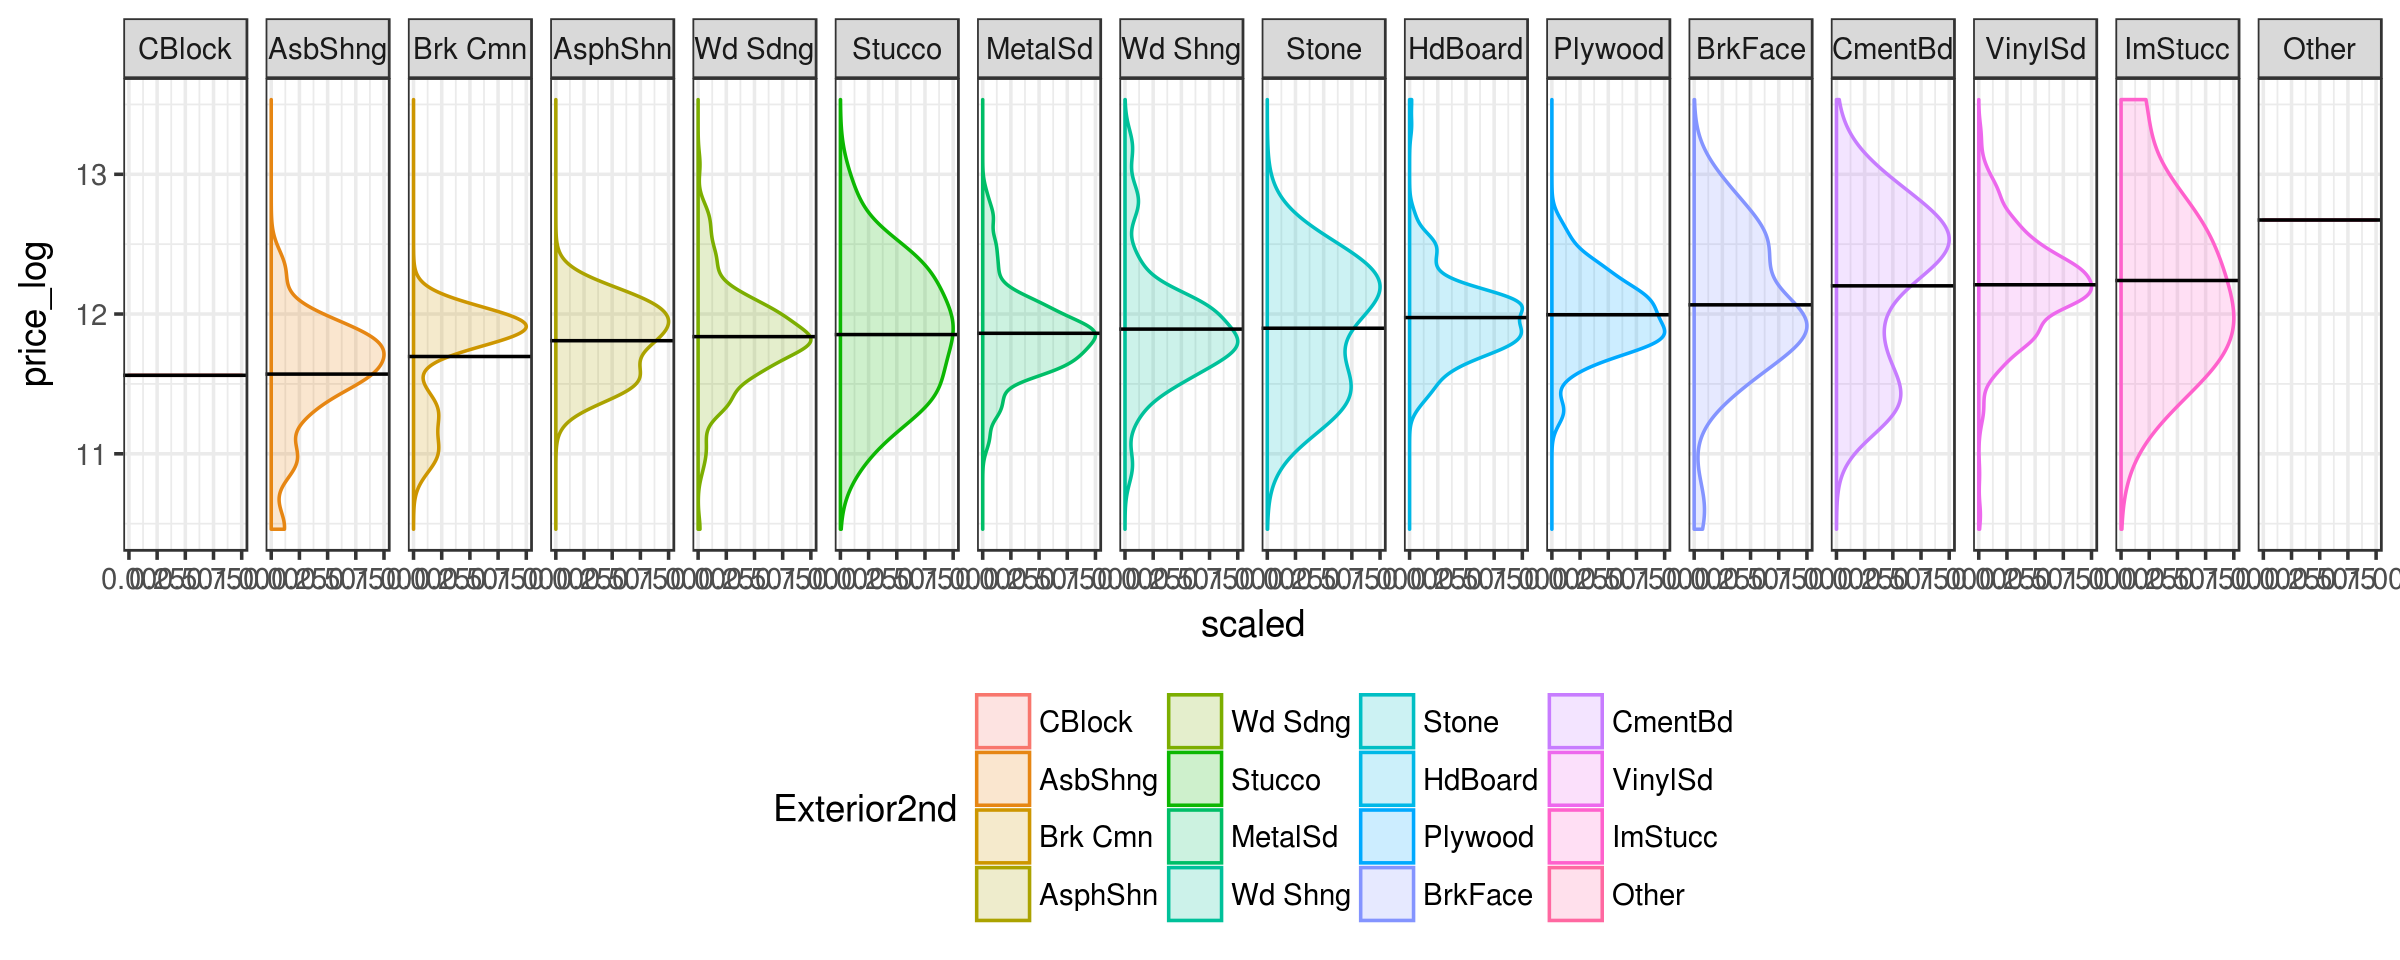

In [120]:
doit(Exterior2nd)

# A tibble: 4 x 3
  ExterQual     n     mean
     <fctr> <int>    <dbl>
1        Fa    14 11.30454
2        TA   906 11.83799
3        Gd   488 12.31128
4        Ex    52 12.76404


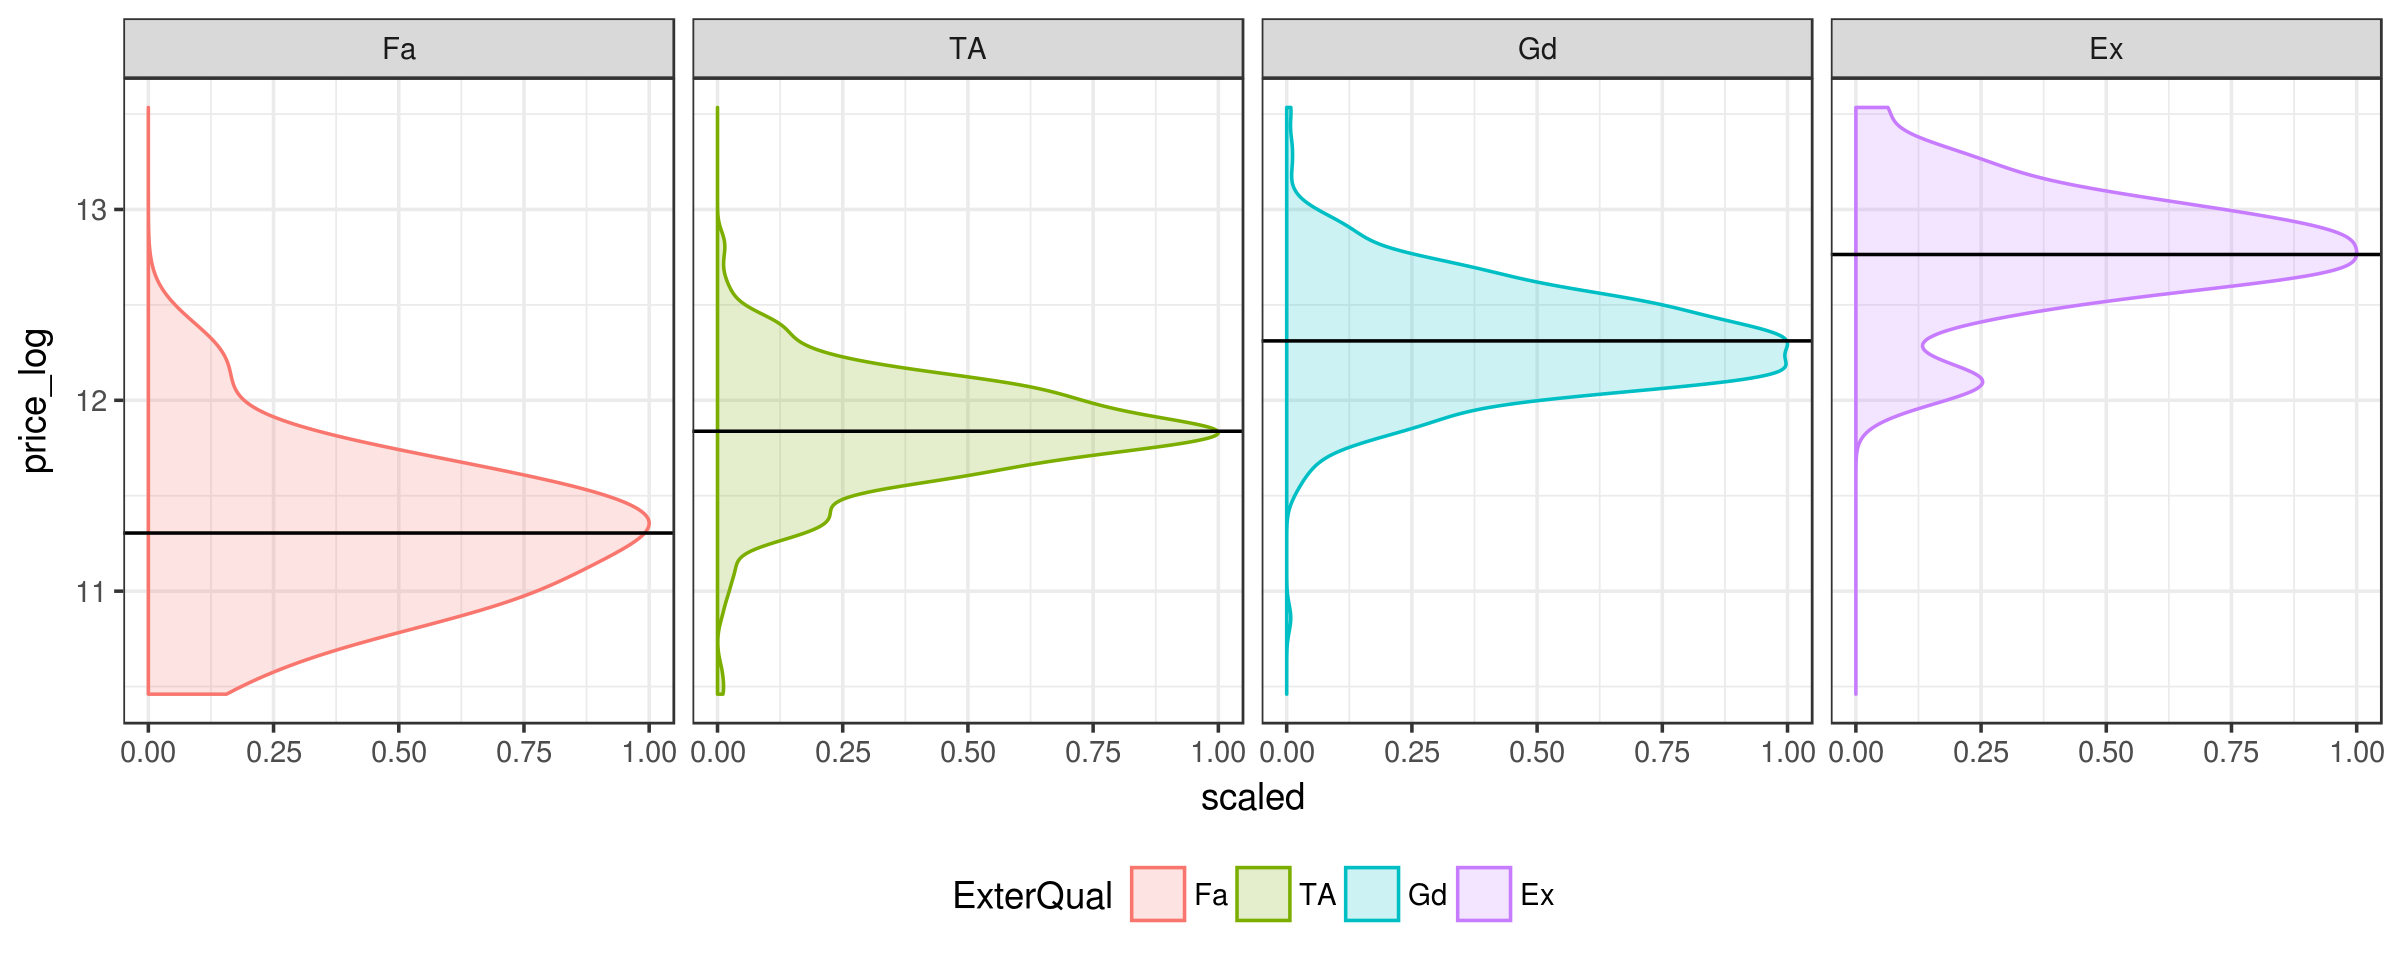

In [121]:
doit(ExterQual)

# A tibble: 5 x 3
   Fence     n     mean
  <fctr> <int>    <dbl>
1   GdWo    54 11.78423
2   MnWw    11 11.79680
3  MnPrv   157 11.85060
4  GdPrv    59 12.05711
5 _none_  1179 12.05860


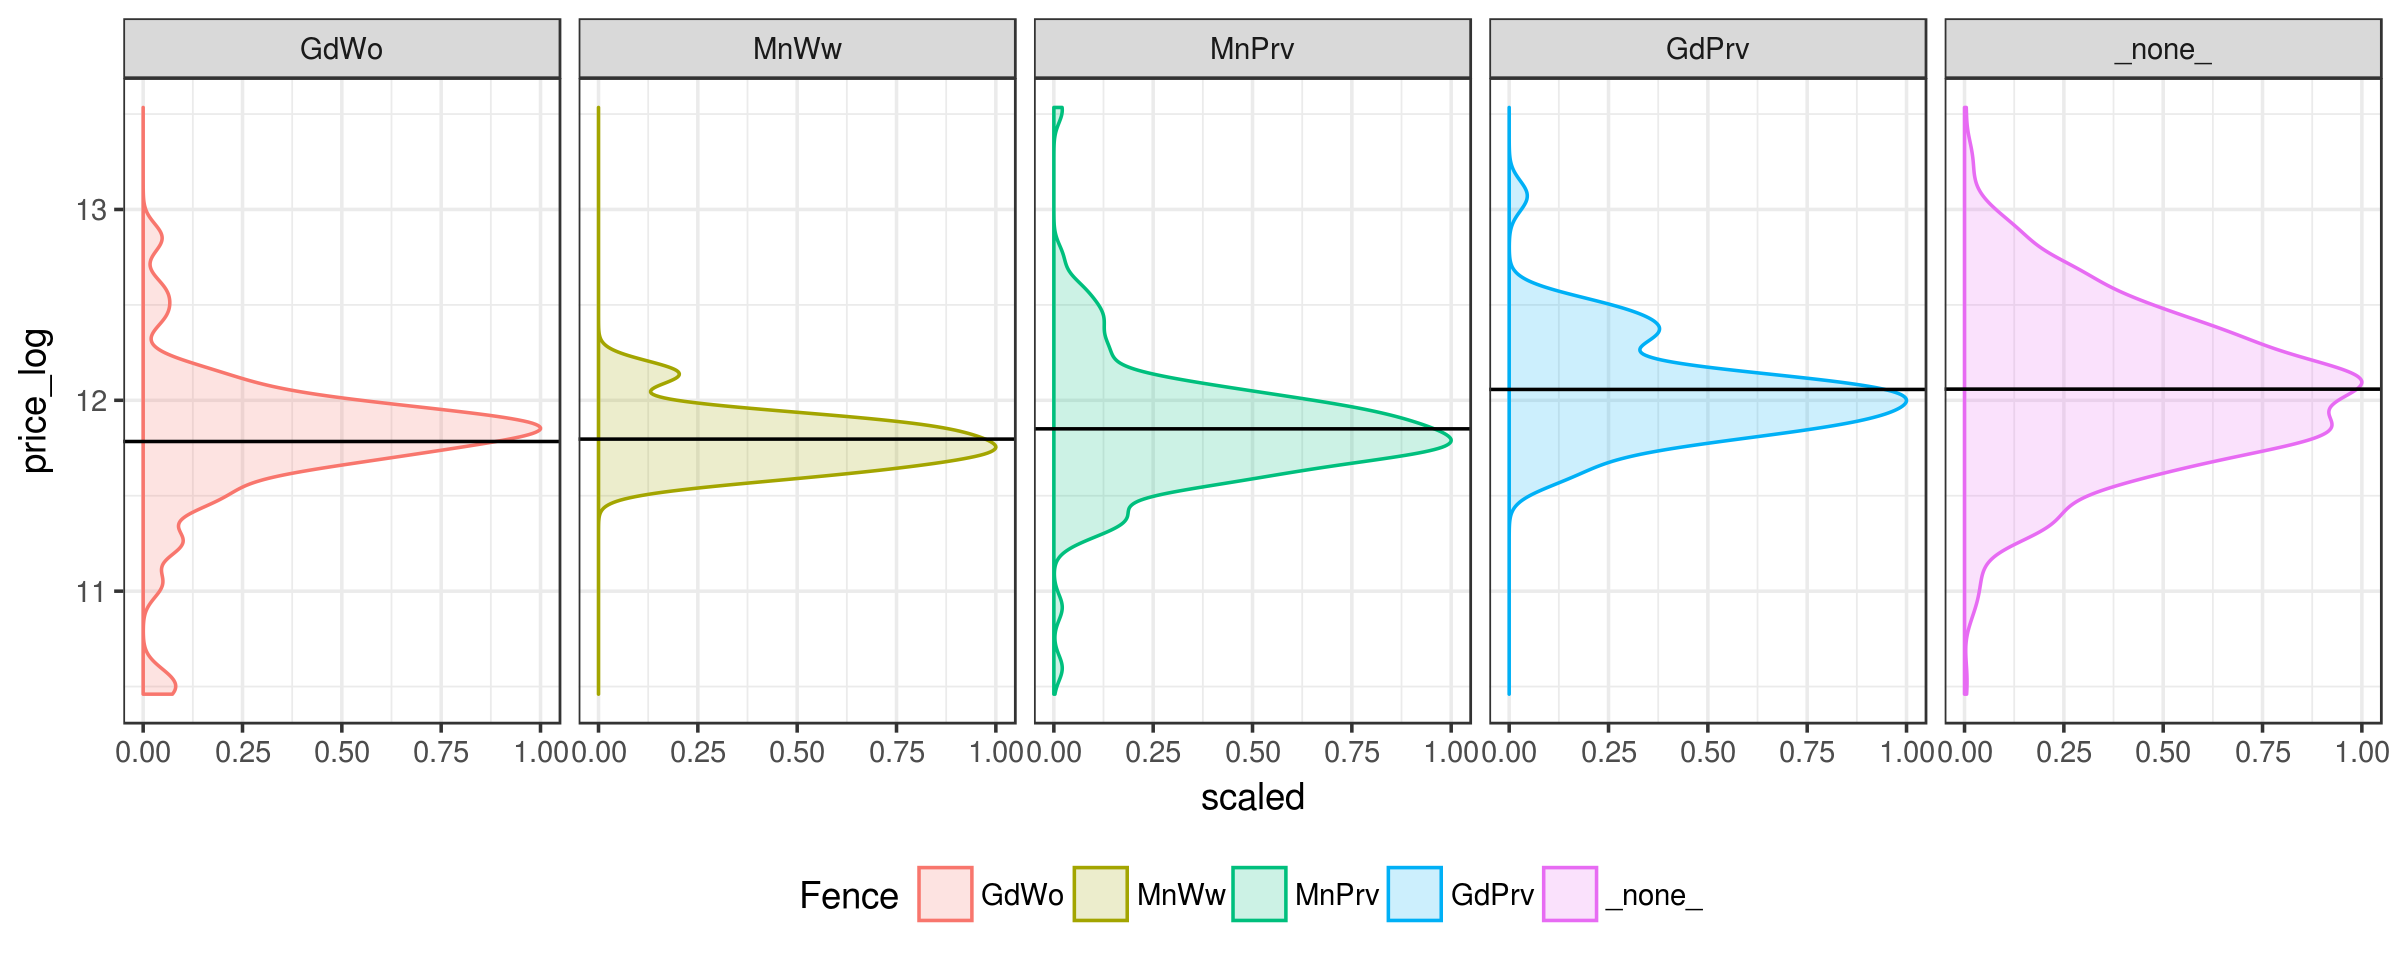

In [122]:
doit(Fence)

# A tibble: 6 x 3
  FireplaceQu     n     mean
       <fctr> <int>    <dbl>
1          Po    20 11.73882
2      _none_   690 11.80891
3          Fa    33 12.00851
4          TA   313 12.18642
5          Gd   380 12.25653
6          Ex    24 12.67002


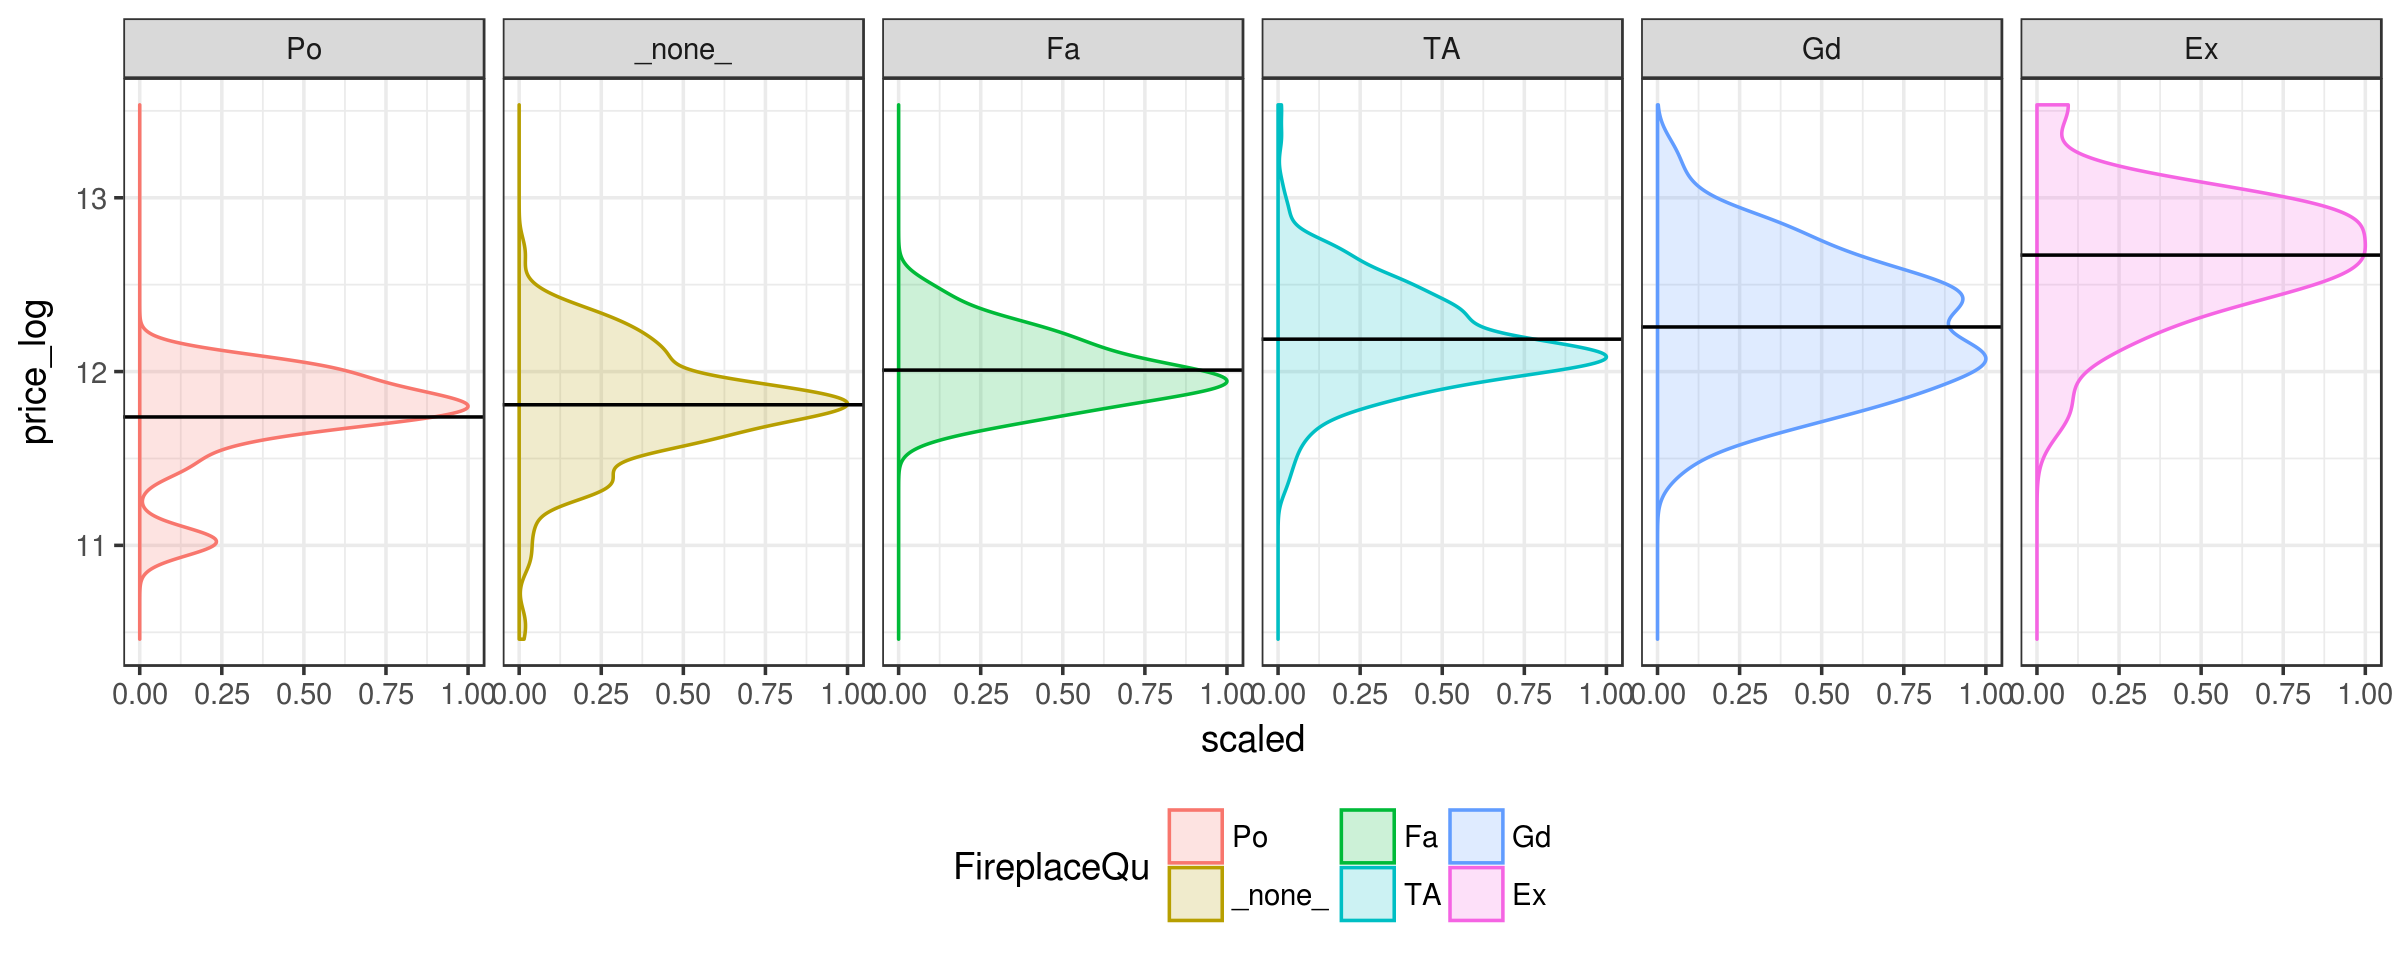

In [123]:
doit(FireplaceQu)

# A tibble: 6 x 3
  Foundation     n     mean
      <fctr> <int>    <dbl>
1       Slab    24 11.53296
2     BrkTil   146 11.72253
3     CBlock   634 11.87008
4      Stone     6 11.93316
5       Wood     3 12.10248
6      PConc   647 12.26167


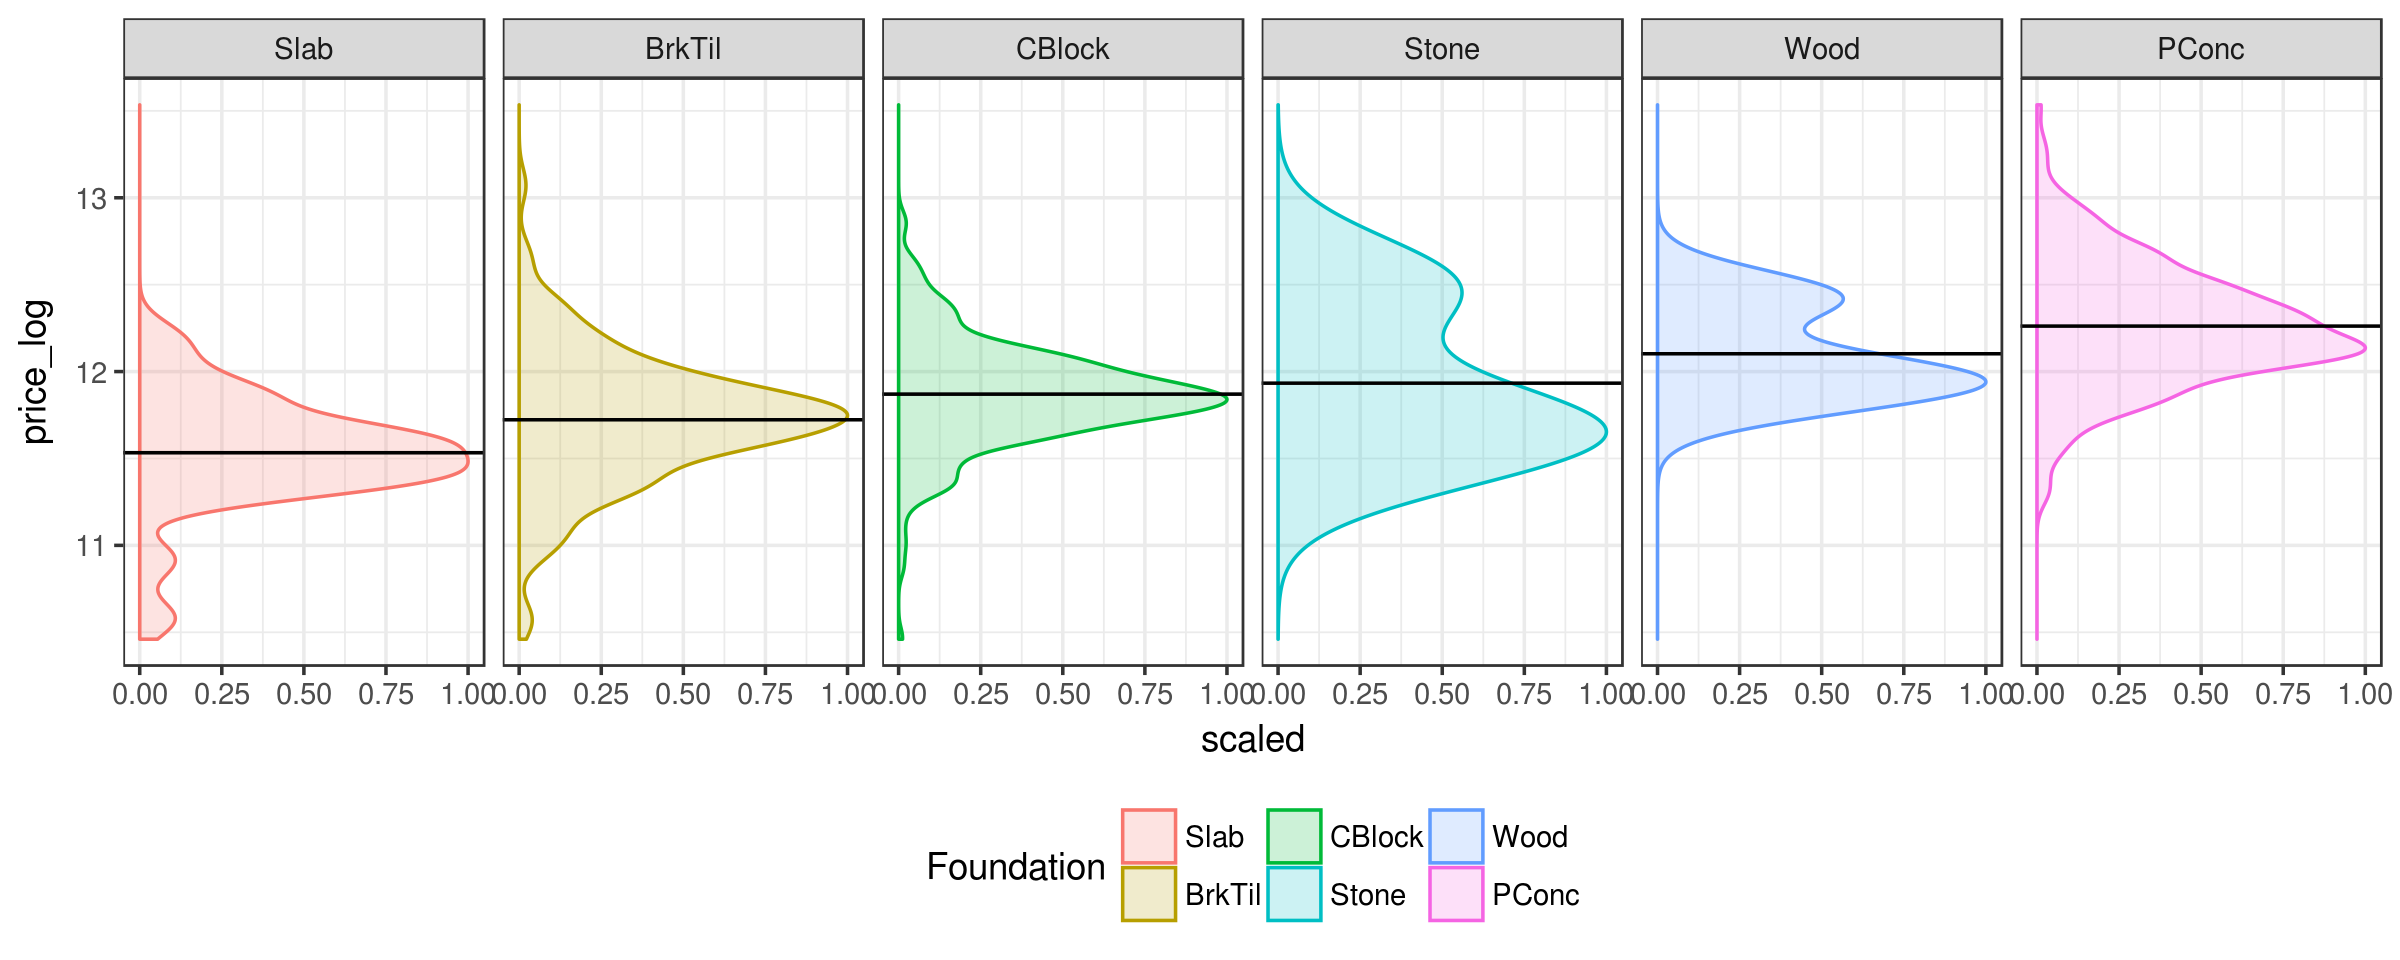

In [124]:
doit(Foundation)

# A tibble: 6 x 3
  GarageCond     n     mean
      <fctr> <int>    <dbl>
1     _none_    81 11.49187
2         Po     7 11.57288
3         Fa    35 11.59688
4         Ex     2 11.72764
5         Gd     9 12.05061
6         TA  1326 12.07048


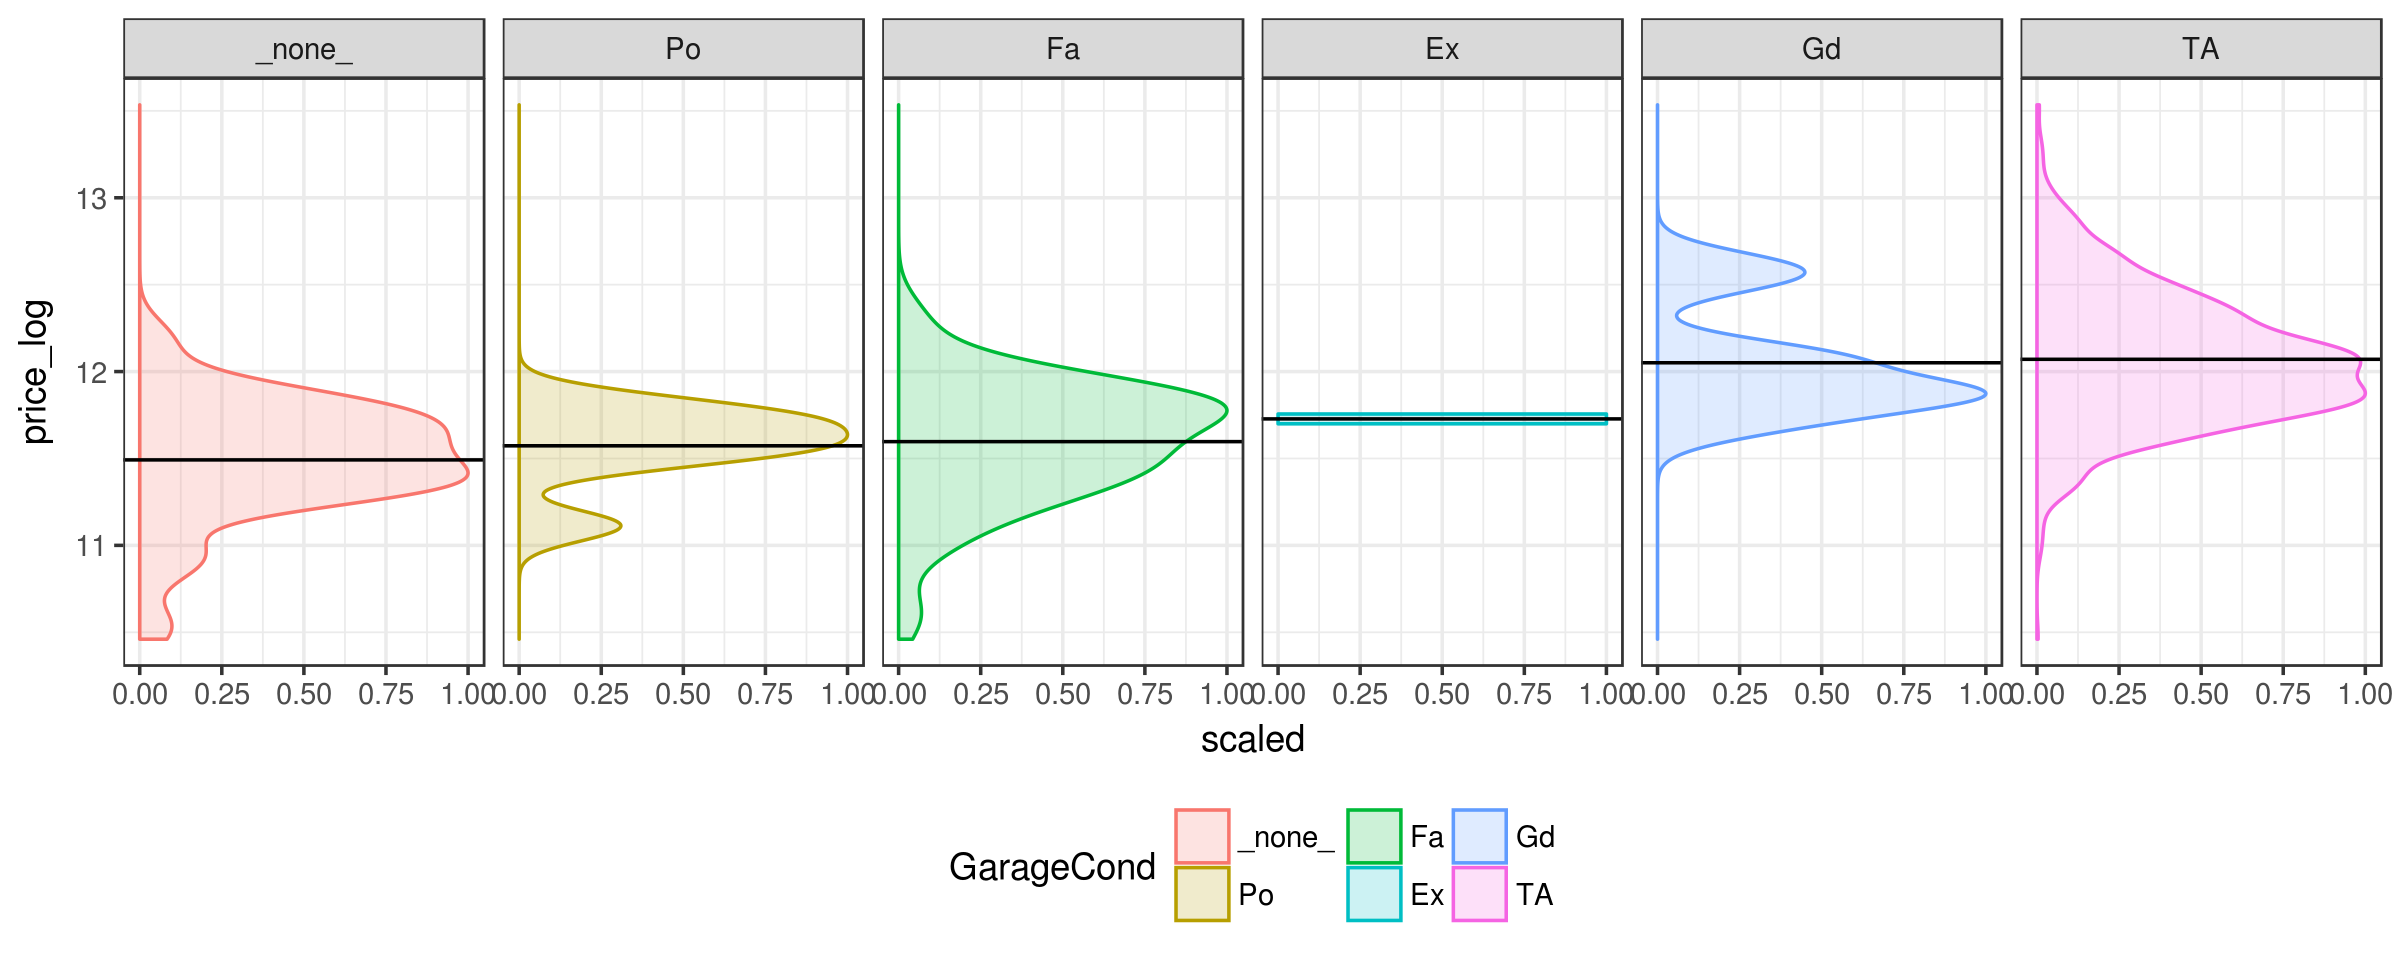

In [125]:
# discarded
doit(GarageCond)

# A tibble: 4 x 3
  GarageFinish     n     mean
        <fctr> <int>    <dbl>
1       _none_    81 11.49187
2          Unf   605 11.81897
3          RFn   422 12.17267
4          Fin   352 12.32081


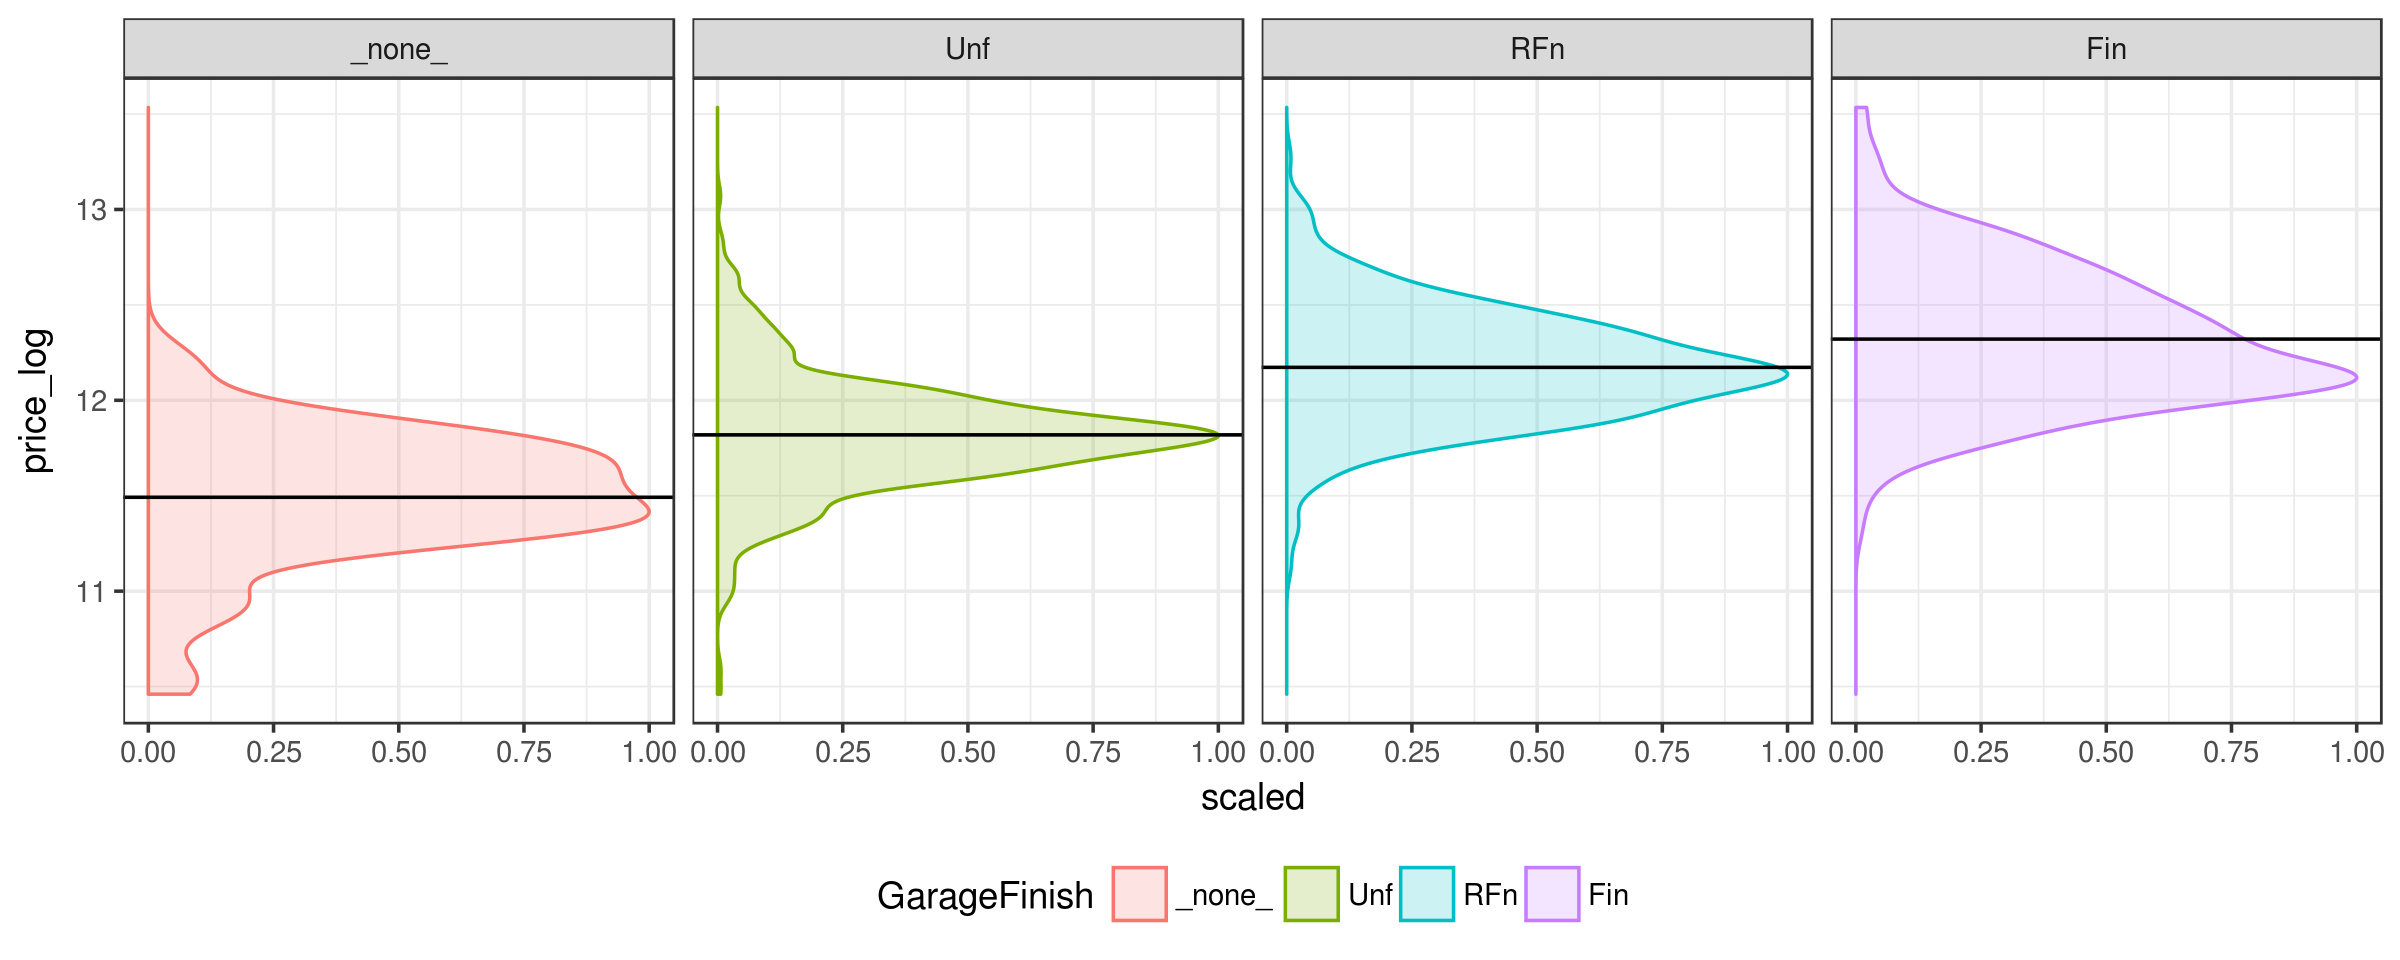

In [126]:
doit(GarageFinish)

# A tibble: 6 x 3
  GarageQual     n     mean
      <fctr> <int>    <dbl>
1         Po     3 11.47249
2     _none_    81 11.49187
3         Fa    48 11.67484
4         TA  1311 12.06854
5         Ex     3 12.17545
6         Gd    14 12.22007


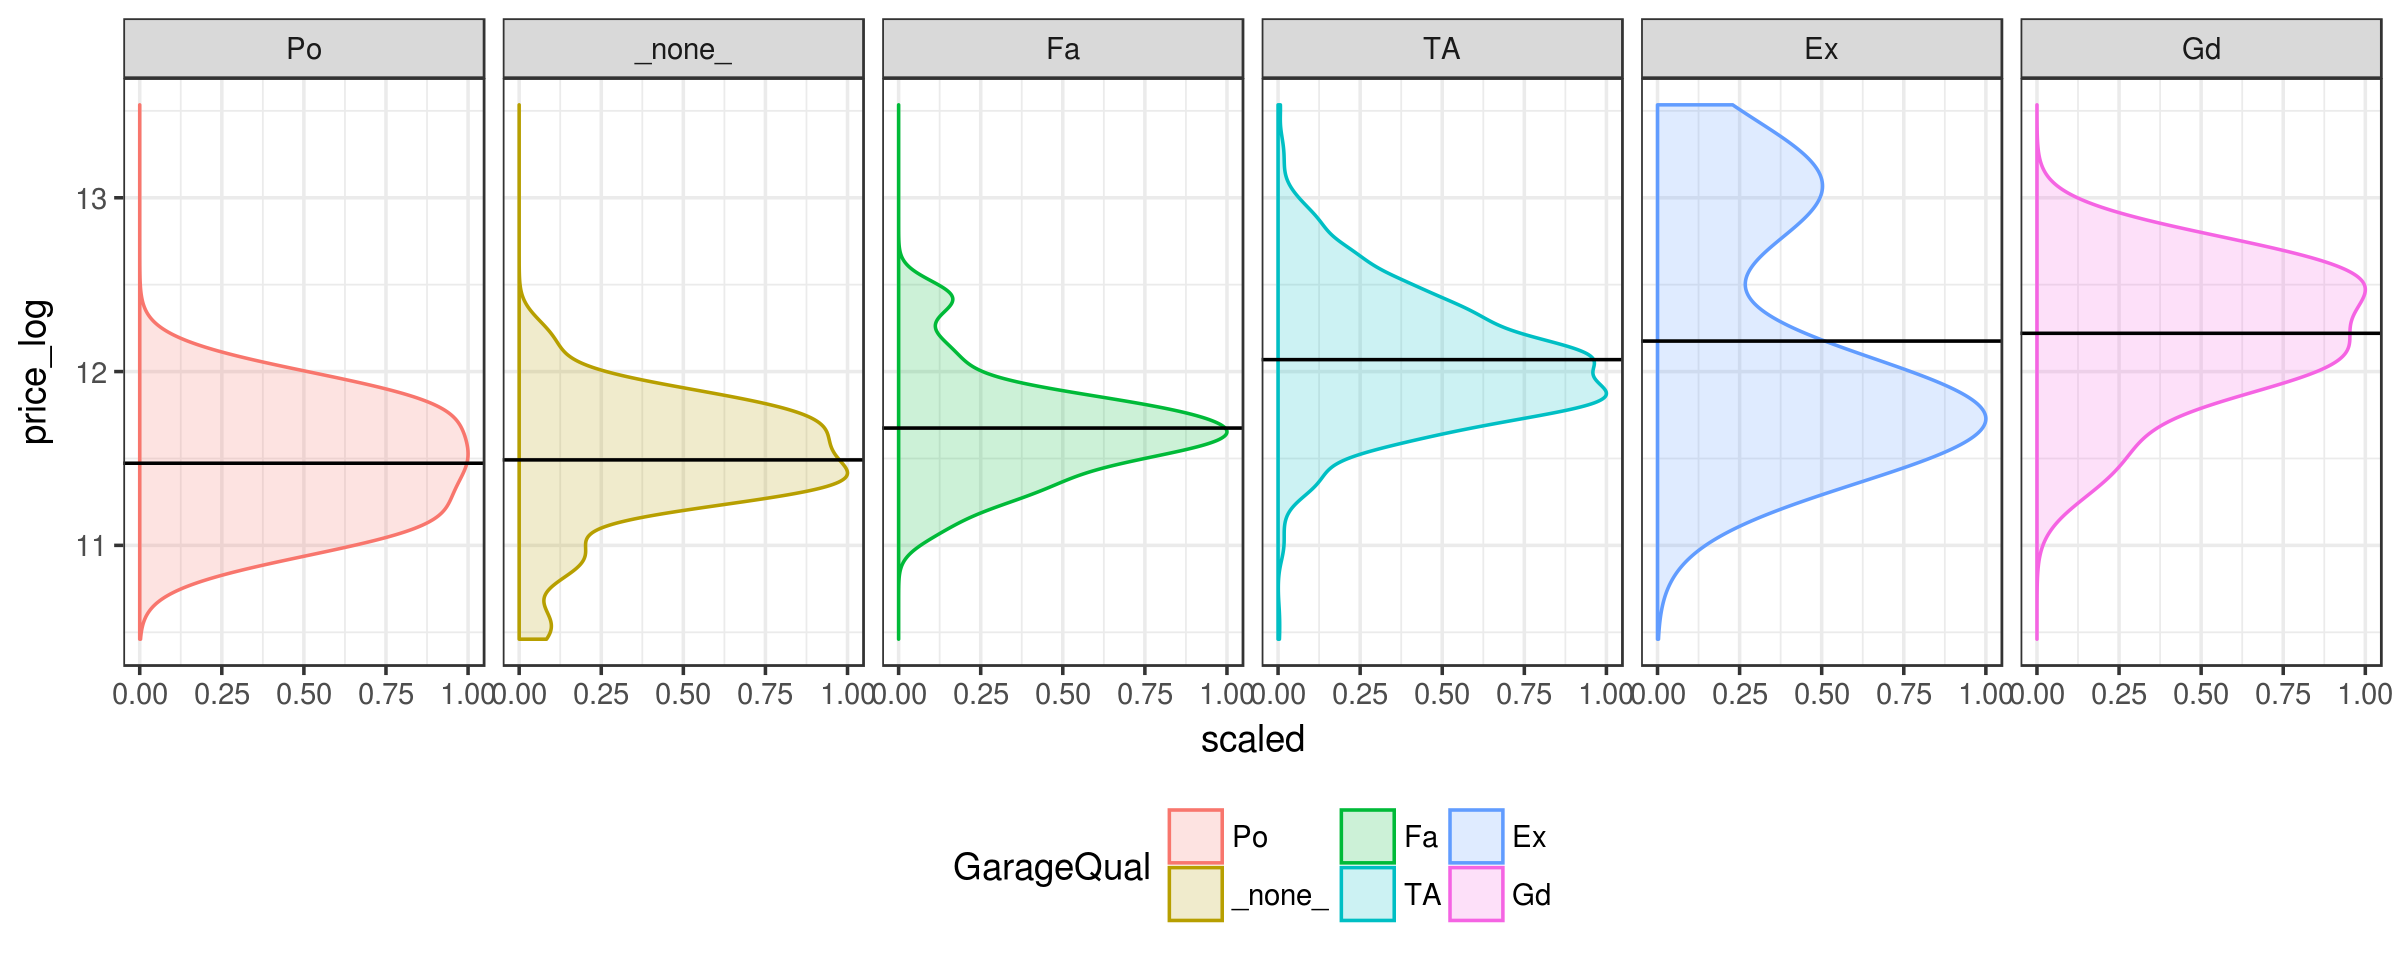

In [127]:
doit(GarageQual)

# A tibble: 7 x 3
  GarageType     n     mean
      <fctr> <int>    <dbl>
1     _none_    81 11.49187
2    CarPort     9 11.58799
3     Detchd   387 11.76564
4     2Types     6 11.89916
5    Basment    19 11.91644
6     Attchd   870 12.16078
7    BuiltIn    88 12.37492


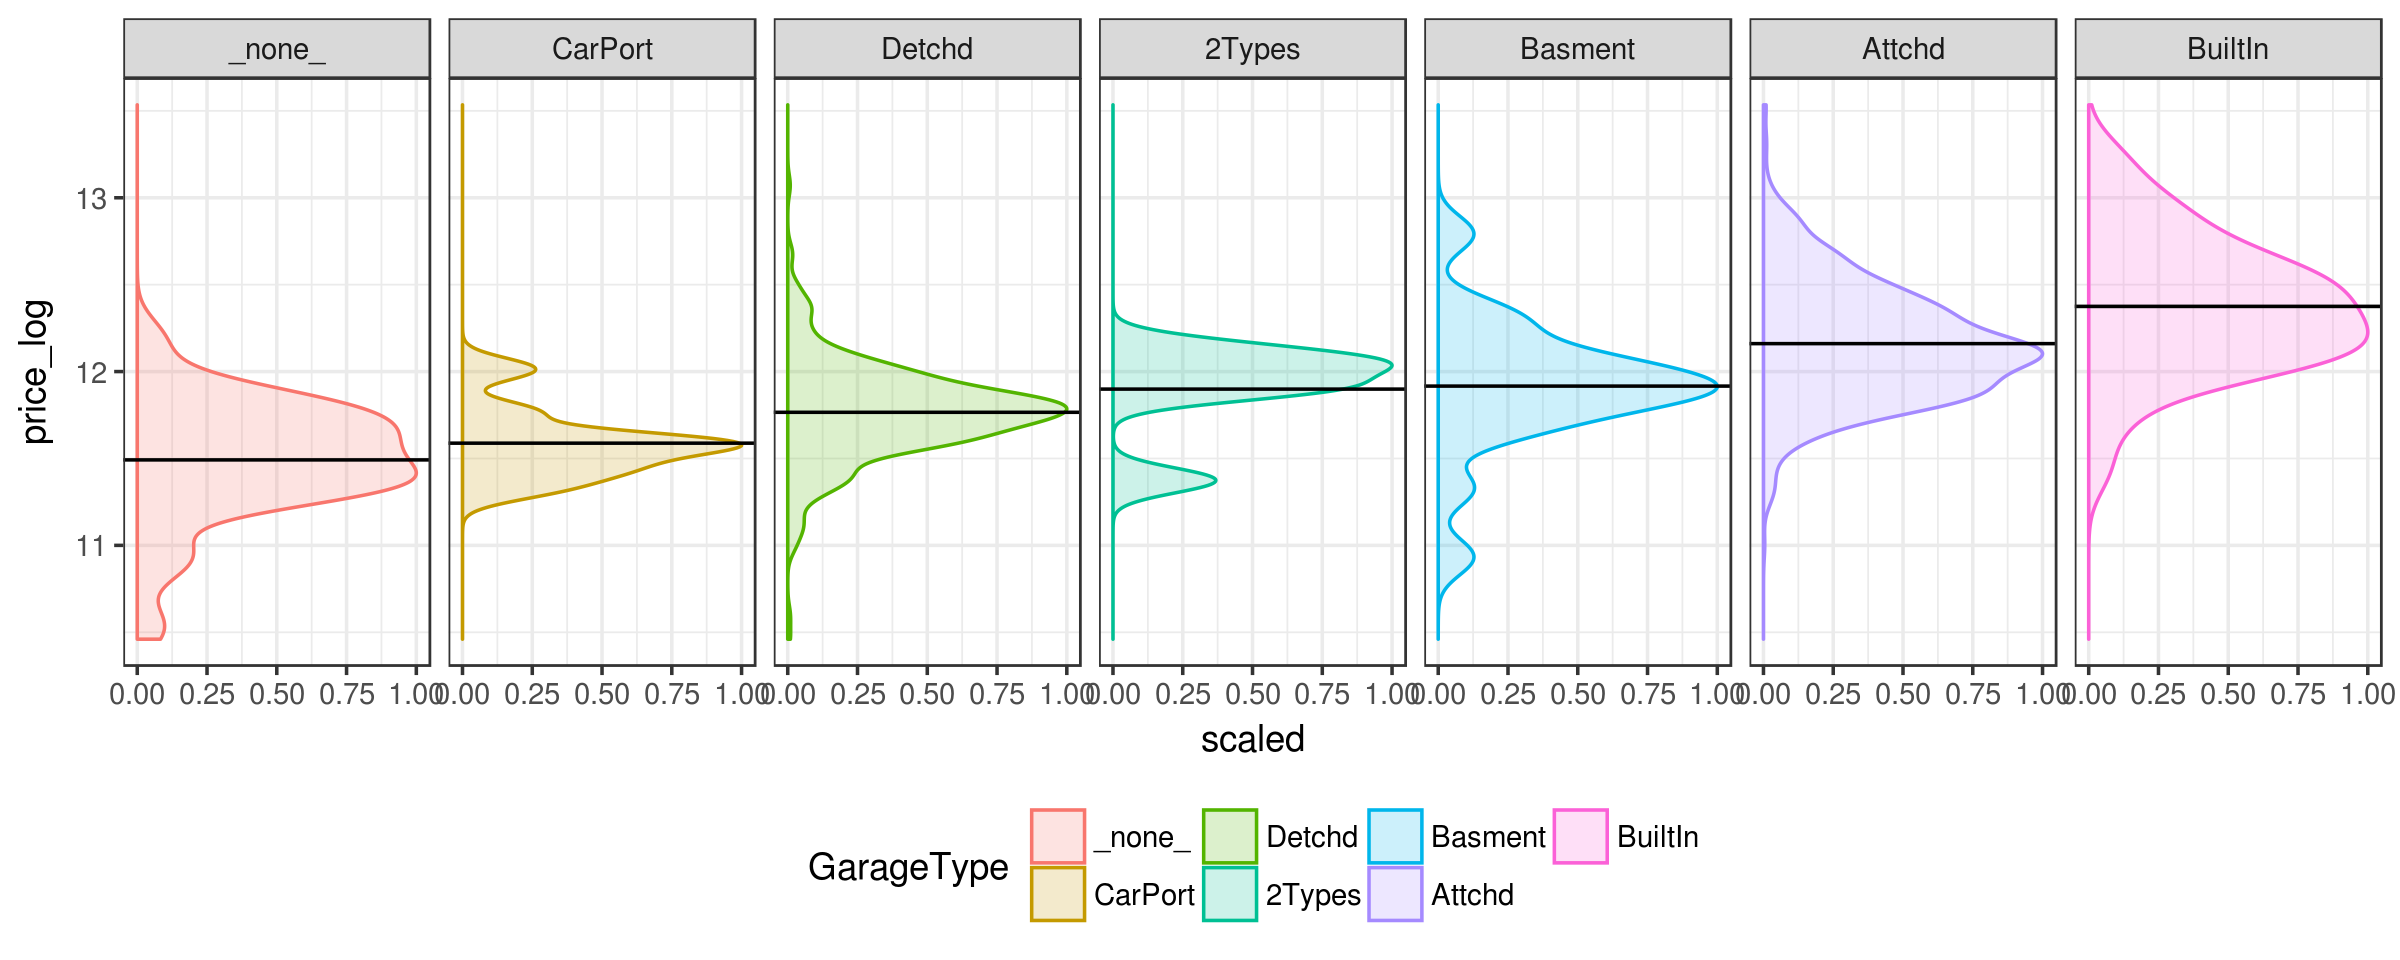

In [128]:
doit(GarageType)

# A tibble: 5 x 3
  HeatingQC     n     mean
     <fctr> <int>    <dbl>
1        Po     1 11.37366
2        Fa    49 11.63703
3        TA   428 11.81606
4        Gd   241 11.91037
5        Ex   741 12.20763


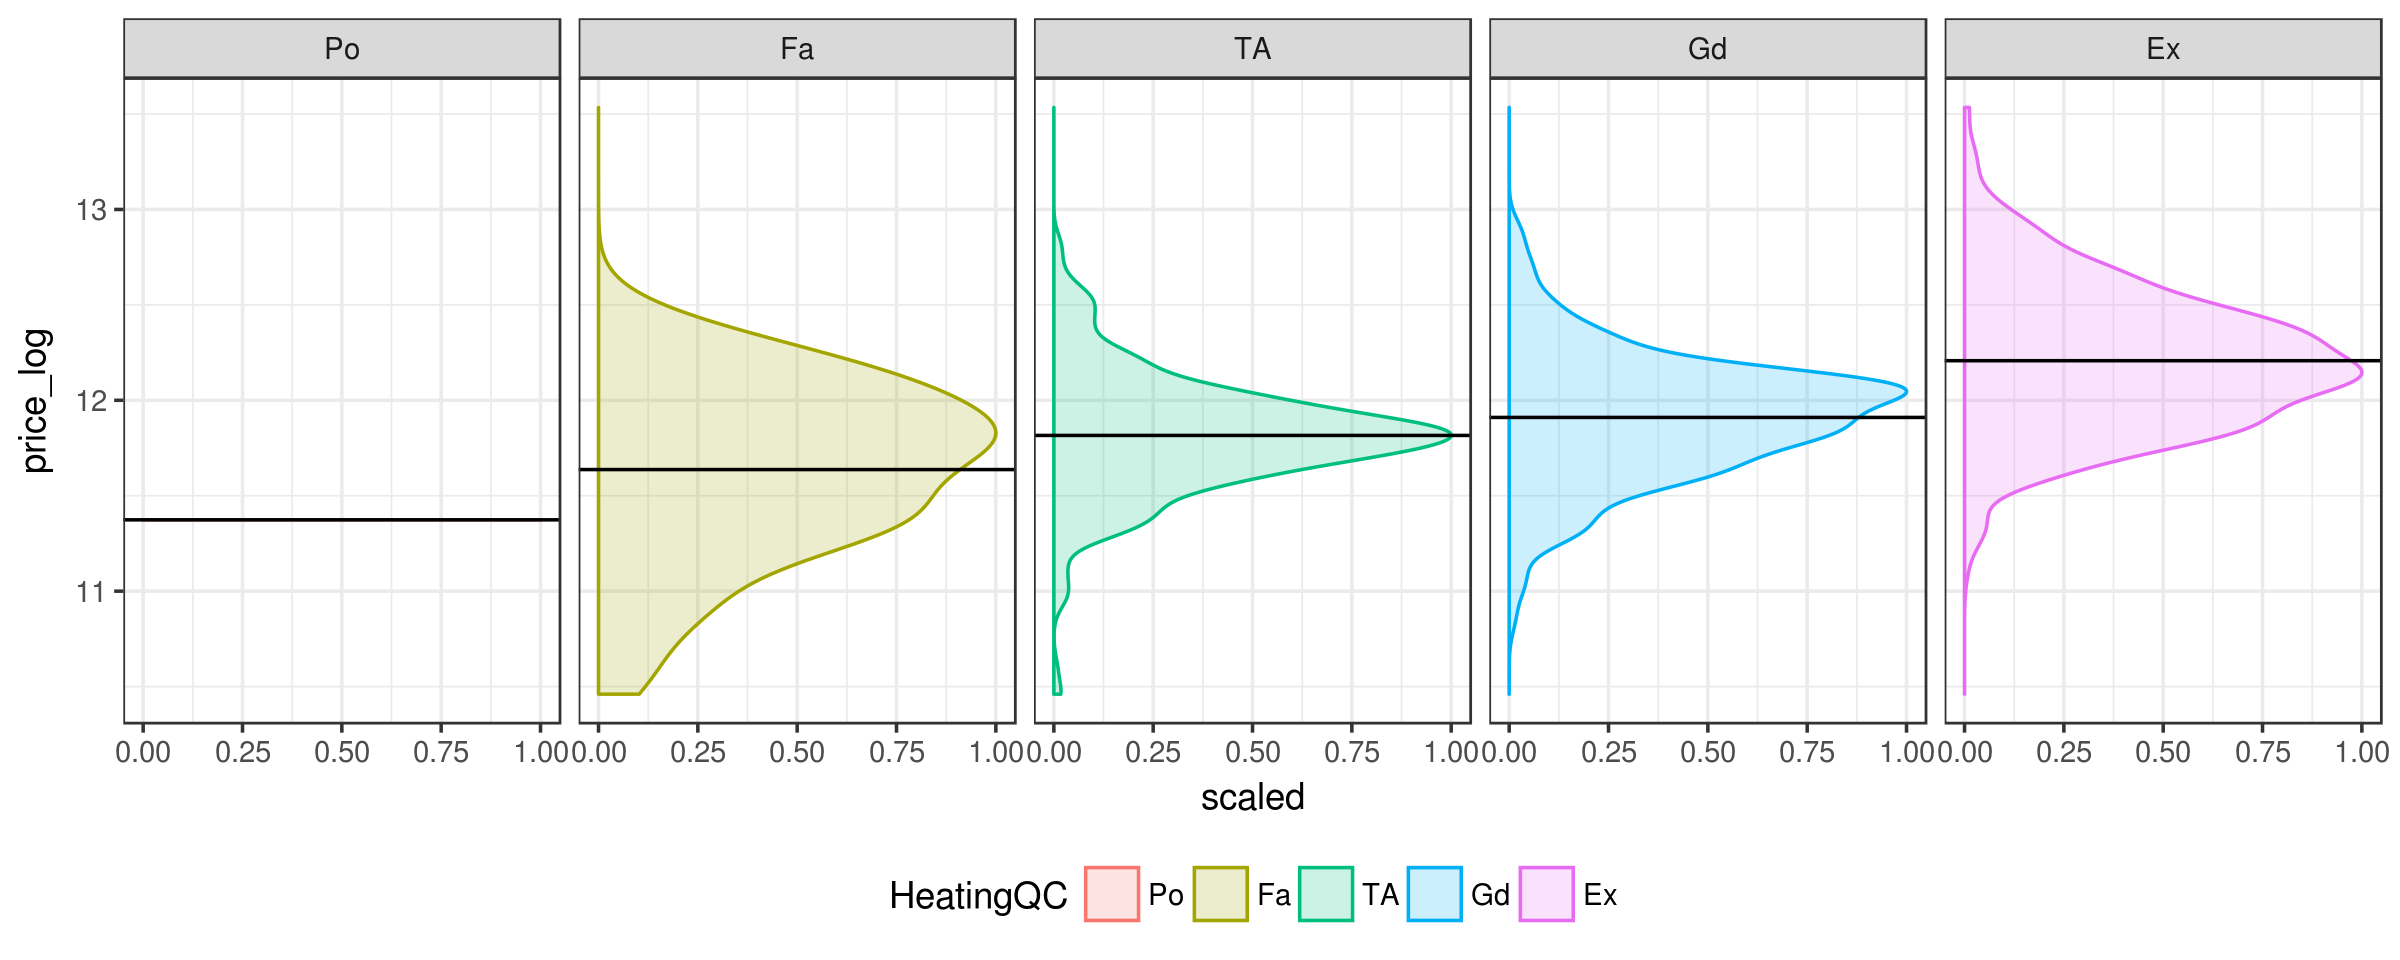

In [129]:
doit(HeatingQC)

In [116]:
categ_data %>% colnames %>% sort

[1] "Alley"         "BldgType"      "BsmtCond"      "BsmtExposure" 
 [5] "BsmtFinType1"  "BsmtQual"      "CentralAir"    "Electrical"   
 [9] "Exterior1st"   "Exterior2nd"   "ExterQual"     "Fence"        
[13] "FireplaceQu"   "Foundation"    "GarageCond"    "GarageFinish" 
[17] "GarageQual"    "GarageType"    "HeatingQC"     "HouseStyle"   
[21] "KitchenQual"   "LandContour"   "LotConfig"     "LotShape"     
[25] "MasVnrType"    "MiscFeature"   "MSSubClass"    "MSZoning"     
[29] "Neighborhood"  "PavedDrive"    "PoolQC"        "price_log"    
[33] "RoofStyle"     "SaleCondition" "SaleType"